# Objective
* 20201111: 
    * Given daily returns for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Using xgboost
    * Date features are not used here
* 20210424:
    * Generate technical indicators as features

In [5976]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import pylab
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as pyo
import scipy.stats as stats
import time

from collections import defaultdict
from datetime import date
from fastai.tabular import add_datepart
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

pyo.init_notebook_mode()

# py.sign_in(<user-name>, <access-key>) # sign in to plotly if you haven't done so

#### Input params ##################
folder = "./data/"
filename = "VTI_20130102_20181231.csv"

# Predicting on day 1008, date 2017-01-03 00:00:00
# Predicting on day 1050, date 2017-03-06 00:00:00
# Predicting on day 1092, date 2017-05-04 00:00:00
# Predicting on day 1134, date 2017-07-05 00:00:00
# Predicting on day 1176, date 2017-09-01 00:00:00
# Predicting on day 1218, date 2017-11-01 00:00:00
# Predicting on day 1260, date 2018-01-03 00:00:00
# Predicting on day 1302, date 2018-03-06 00:00:00
# Predicting on day 1344, date 2018-05-04 00:00:00
# Predicting on day 1386, date 2018-07-05 00:00:00
# Predicting on day 1428, date 2018-09-04 00:00:00
# Predicting on day 1470, date 2018-11-01 00:00:00

pred_date = '2017-01-03'        # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                 # Use 1 year of data as validation set
N = 10                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [5977]:
tic1 = time.time()

# Common functions

In [5978]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_wape(y_true, y_pred): 
    """
    Compute weighted absolute percentage error (WAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return sum(np.abs(y_true - y_pred)) / sum(y_true) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [5979]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out



def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df_w_lags


## get_sma

In [5980]:
def get_sma(X, df):
    """
    Get features related to simple moving average
    Inputs
        X  : dataframe without the SMA features
        df : dataframe containing 'adj_close' column. To generate features for the last row in this dataframe.
    Outputs
        X  : X with additional SMA features
    """
    
    # Simple moving average
    df['sma_10'] = df['adj_close'].rolling(window = 10).mean()
    df['sma_20'] = df['adj_close'].rolling(window = 20).mean()
    df['sma_50'] = df['adj_close'].rolling(window = 50).mean()
    df['sma_100'] = df['adj_close'].rolling(window = 100).mean()
    df['sma_200'] = df['adj_close'].rolling(window = 200).mean()

    # Get the sma on the previous day
    df['adj_close_lag_1'] = df['adj_close'].shift(1)
    df['sma_10_lag_1'] = df['sma_10'].shift(1)
    df['sma_20_lag_1'] = df['sma_20'].shift(1)
    df['sma_50_lag_1'] = df['sma_50'].shift(1)
    df['sma_100_lag_1'] = df['sma_100'].shift(1)
    df['sma_200_lag_1'] = df['sma_200'].shift(1)

    # Get above signals
    df['sma_above20'] = (df['adj_close'] > df['sma_20']).astype(int)
    df['sma_above50'] = (df['adj_close'] > df['sma_50']).astype(int)
    df['sma_above100'] = (df['adj_close'] > df['sma_100']).astype(int)
    df['sma_above200'] = (df['adj_close'] > df['sma_200']).astype(int)

    df['sma_10above20'] = (df['sma_10'] > df['sma_20']).astype(int)
    df['sma_10above50'] = (df['sma_10'] > df['sma_50']).astype(int)
    df['sma_10above100'] = (df['sma_10'] > df['sma_100']).astype(int)
    df['sma_10above200'] = (df['sma_10'] > df['sma_200']).astype(int)

    # Get bullish crossover signals
    df['sma_cut20'] = ((df['adj_close_lag_1'] < df['sma_20_lag_1']) & (df['sma_above20']==True)).astype(int)
    df['sma_cut50'] = ((df['adj_close_lag_1'] < df['sma_50_lag_1']) & (df['sma_above50']==True)).astype(int)
    df['sma_cut100'] = ((df['adj_close_lag_1'] < df['sma_100_lag_1']) & (df['sma_above100']==True)).astype(int)
    df['sma_cut200'] = ((df['adj_close_lag_1'] < df['sma_200_lag_1']) & (df['sma_above200']==True)).astype(int)

    df['sma_10cut20'] = ((df['sma_10_lag_1'] < df['sma_20_lag_1']) & (df['sma_10above20']==True)).astype(int)
    df['sma_10cut50'] = ((df['sma_10_lag_1'] < df['sma_50_lag_1']) & (df['sma_10above50']==True)).astype(int)
    df['sma_10cut100'] = ((df['sma_10_lag_1'] < df['sma_100_lag_1']) & (df['sma_10above100']==True)).astype(int)
    df['sma_10cut200'] = ((df['sma_10_lag_1'] < df['sma_200_lag_1']) & (df['sma_10above200']==True)).astype(int)

    # Get bearish crossover signals
    df['sma_cut20down'] = ((df['adj_close_lag_1'] > df['sma_20_lag_1']) & (df['adj_close'] < df['sma_20'])).astype(int)
    df['sma_cut50down'] = ((df['adj_close_lag_1'] > df['sma_50_lag_1']) & (df['adj_close'] < df['sma_50'])).astype(int)
    df['sma_cut100down'] = ((df['adj_close_lag_1'] > df['sma_100_lag_1']) & (df['adj_close'] < df['sma_100'])).astype(int)
    df['sma_cut200down'] = ((df['adj_close_lag_1'] > df['sma_200_lag_1']) & (df['adj_close'] < df['sma_200'])).astype(int)

    df['sma_10cut20down'] = ((df['sma_10_lag_1'] > df['sma_20_lag_1']) & (df['sma_10'] < df['sma_20'])).astype(int)
    df['sma_10cut50down'] = ((df['sma_10_lag_1'] > df['sma_50_lag_1']) & (df['sma_10'] < df['sma_50'])).astype(int)
    df['sma_10cut100down'] = ((df['sma_10_lag_1'] > df['sma_100_lag_1']) & (df['sma_10'] < df['sma_100'])).astype(int)
    df['sma_10cut200down'] = ((df['sma_10_lag_1'] > df['sma_200_lag_1']) & (df['sma_10'] < df['sma_200'])).astype(int)
    
    tech_features = [   'sma_above20',
                        'sma_above50',
                        'sma_above100',
                        'sma_above200',
                        'sma_10above20',
                        'sma_10above50',
                        'sma_10above100',
                        'sma_10above200',
                        'sma_cut20',
                        'sma_cut50',
                        'sma_cut100',
                        'sma_cut200',
                        'sma_10cut20',
                        'sma_10cut50',
                        'sma_10cut100',
                        'sma_10cut200',
                        'sma_cut20down',
                        'sma_cut50down',
                        'sma_cut100down',
                        'sma_cut200down',
                        'sma_10cut20down',
                        'sma_10cut50down',
                        'sma_10cut100down',
                        'sma_10cut200down'
                    ]
    
    features_df = df[tech_features][-1:].reset_index(drop=True)
    features_df.columns = [item+'_lag_1' for item in tech_features]
    
    return pd.concat([X, features_df], axis=1)

## get_ema

In [5981]:
def get_ema(X, df):
    """
    Get features related to exponential moving average
    Inputs
        X  : dataframe without the EMA features
        df : dataframe containing 'adj_close' column. To generate features for the last row in this dataframe.
    Outputs
        X  : X with additional EMA features
    """
    
    # Exponential moving average
    df['ema_10'] = df['adj_close'].ewm(span = 10, adjust=False).mean()
    df['ema_20'] = df['adj_close'].ewm(span = 20, adjust=False).mean()
    df['ema_50'] = df['adj_close'].ewm(span = 50, adjust=False).mean()
    df['ema_100'] = df['adj_close'].ewm(span = 100, adjust=False).mean()
    df['ema_200'] = df['adj_close'].ewm(span = 200, adjust=False).mean()

    # Get the ema on the previous day
    df['adj_close_lag_1'] = df['adj_close'].shift(1)
    df['ema_10_lag_1'] = df['ema_10'].shift(1)
    df['ema_20_lag_1'] = df['ema_20'].shift(1)
    df['ema_50_lag_1'] = df['ema_50'].shift(1)
    df['ema_100_lag_1'] = df['ema_100'].shift(1)
    df['ema_200_lag_1'] = df['ema_200'].shift(1)

    # Get above signals
    df['ema_above20'] = (df['adj_close'] > df['ema_20']).astype(int)
    df['ema_above50'] = (df['adj_close'] > df['ema_50']).astype(int)
    df['ema_above100'] = (df['adj_close'] > df['ema_100']).astype(int)
    df['ema_above200'] = (df['adj_close'] > df['ema_200']).astype(int)

    df['ema_10above20'] = (df['ema_10'] > df['ema_20']).astype(int)
    df['ema_10above50'] = (df['ema_10'] > df['ema_50']).astype(int)
    df['ema_10above100'] = (df['ema_10'] > df['ema_100']).astype(int)
    df['ema_10above200'] = (df['ema_10'] > df['ema_200']).astype(int)

    # Get bullish crossover signals
    df['ema_cut20'] = ((df['adj_close_lag_1'] < df['ema_20_lag_1']) & (df['ema_above20']==True)).astype(int)
    df['ema_cut50'] = ((df['adj_close_lag_1'] < df['ema_50_lag_1']) & (df['ema_above50']==True)).astype(int)
    df['ema_cut100'] = ((df['adj_close_lag_1'] < df['ema_100_lag_1']) & (df['ema_above100']==True)).astype(int)
    df['ema_cut200'] = ((df['adj_close_lag_1'] < df['ema_200_lag_1']) & (df['ema_above200']==True)).astype(int)

    df['ema_10cut20'] = ((df['ema_10_lag_1'] < df['ema_20_lag_1']) & (df['ema_10above20']==True)).astype(int)
    df['ema_10cut50'] = ((df['ema_10_lag_1'] < df['ema_50_lag_1']) & (df['ema_10above50']==True)).astype(int)
    df['ema_10cut100'] = ((df['ema_10_lag_1'] < df['ema_100_lag_1']) & (df['ema_10above100']==True)).astype(int)
    df['ema_10cut200'] = ((df['ema_10_lag_1'] < df['ema_200_lag_1']) & (df['ema_10above200']==True)).astype(int)

    # Get bearish crossover signals
    df['ema_cut20down'] = ((df['adj_close_lag_1'] > df['ema_20_lag_1']) & (df['adj_close'] < df['ema_20'])).astype(int)
    df['ema_cut50down'] = ((df['adj_close_lag_1'] > df['ema_50_lag_1']) & (df['adj_close'] < df['ema_50'])).astype(int)
    df['ema_cut100down'] = ((df['adj_close_lag_1'] > df['ema_100_lag_1']) & (df['adj_close'] < df['ema_100'])).astype(int)
    df['ema_cut200down'] = ((df['adj_close_lag_1'] > df['ema_200_lag_1']) & (df['adj_close'] < df['ema_200'])).astype(int)

    df['ema_10cut20down'] = ((df['ema_10_lag_1'] > df['ema_20_lag_1']) & (df['ema_10'] < df['ema_20'])).astype(int)
    df['ema_10cut50down'] = ((df['ema_10_lag_1'] > df['ema_50_lag_1']) & (df['ema_10'] < df['ema_50'])).astype(int)
    df['ema_10cut100down'] = ((df['ema_10_lag_1'] > df['ema_100_lag_1']) & (df['ema_10'] < df['ema_100'])).astype(int)
    df['ema_10cut200down'] = ((df['ema_10_lag_1'] > df['ema_200_lag_1']) & (df['ema_10'] < df['ema_200'])).astype(int)
    
    tech_features = [   
                        'ema_above20',
                        'ema_above50',
                        'ema_above100',
                        'ema_above200',
                        'ema_10above20',
                        'ema_10above50',
                        'ema_10above100',
                        'ema_10above200',
                        'ema_cut20',
                        'ema_cut50',
                        'ema_cut100',
                        'ema_cut200',
                        'ema_10cut20',
                        'ema_10cut50',
                        'ema_10cut100',
                        'ema_10cut200',
                        'ema_cut20down',
                        'ema_cut50down',
                        'ema_cut100down',
                        'ema_cut200down',
                        'ema_10cut20down',
                        'ema_10cut50down',
                        'ema_10cut100down',
                        'ema_10cut200down'
                    ]
    
    features_df = df[tech_features][-1:].reset_index(drop=True)
    features_df.columns = [item+'_lag_1' for item in tech_features]

    return pd.concat([X, features_df], axis=1)

## get_macd

In [5982]:
def get_macd(X, df):
    """
    Get features related to exponential moving average
    Inputs
        X  : dataframe without the MACD features
        df : dataframe containing 'adj_close' column. To generate features for the last row in this dataframe.
    Outputs
        X  : X with additional MACD features
    """

    # Exponential moving average
    df['ema_12'] = df['adj_close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['adj_close'].ewm(span=26, adjust=False).mean()

    # MACD
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Get the macd on the previous day
    df['macd_lag_1'] = df['macd'].shift(1)
    df['macd_signal_lag_1'] = df['macd_signal'].shift(1)

    # Get bullish crossover signals
    df['macd_crossover'] = ((df['macd_lag_1'] < df['macd_signal_lag_1']) & \
                            (df['macd'] > df['macd_signal'])).astype(int)
    
    # Get bearish crossover signals
    df['macd_crossoverdown'] = ((df['macd_lag_1'] > df['macd_signal_lag_1']) & \
                        (df['macd'] < df['macd_signal'])).astype(int)


    tech_features = [   
                        'macd',
                        'macd_crossover',
                        'macd_crossoverdown'
                    ]
    
    features_df = df[tech_features][-1:].reset_index(drop=True)
    features_df.columns = [item+'_lag_1' for item in tech_features]

    return pd.concat([X, features_df], axis=1)

## get_stochastic_osc

In [5983]:
def get_stochastic_osc(X, df):
    """
    Get features related to stochastic oscillator
    Inputs
        X  : dataframe without the stochastic oscillator features
        df : dataframe containing 'adj_close' column. To generate features for the last row in this dataframe.
    Outputs
        X  : X with additional stochastic oscillator features
    """

    # Generate fast and slow stochastic oscillators
    df['lowest_14'] = df['adj_close'].rolling(window = 14).min()
    df['highest_14'] = df['adj_close'].rolling(window = 14).max()
    df['stochastic_fast'] = 100.0*(df['adj_close'] - df['lowest_14'])/(df['highest_14'] - df['lowest_14'])
    df['stochastic_slow'] = df['stochastic_fast'].rolling(window = 3).mean()

    # Get the stochastics on the previous day
    df['stochastic_fast_lag_1'] = df['stochastic_fast'].shift(1)
    df['stochastic_slow_lag_1'] = df['stochastic_slow'].shift(1)

    # Get bullish crossover signals
    df['stochastic_fastcutslow'] = ((df['stochastic_fast_lag_1'] < df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] > df['stochastic_slow'])).astype(int)

    # Get bearish crossover signals
    df['stochastic_fastcutslowdown'] = ((df['stochastic_fast_lag_1'] > df['stochastic_slow_lag_1']) & \
                                        (df['stochastic_fast'] < df['stochastic_slow'])).astype(int)
    
    # Get overbought/oversold signals
    df['stochastic_overs'] = (df['stochastic_fast'] < 20).astype(int)
    df['stochastic_overb'] = (df['stochastic_fast'] > 80).astype(int)

    tech_features = [   
                        'stochastic_fast',
                        'stochastic_slow',
                        'stochastic_fastcutslow',
                        'stochastic_fastcutslowdown',
                        'stochastic_overs',
                        'stochastic_overb'
                    ]
    
    features_df = df[tech_features][-1:].reset_index(drop=True)
    features_df.columns = [item+'_lag_1' for item in tech_features]

    return pd.concat([X, features_df], axis=1)

## get_rsi

In [5984]:
def get_rsi(X, df):
    """
    Get features related to rsi
    Inputs
        X  : dataframe without the rsi features
        df : dataframe containing 'adj_close' column. To generate features for the last row in this dataframe.
    Outputs
        X  : X with additional rsi features
    """
    
    # Get gain and loss columns
    df['gain'] = df['daily_ret']
    df.loc[df['gain']<0, 'gain'] = 0

    df['loss'] = df['daily_ret']
    df.loc[df['loss']>0, 'loss'] = 0
    df['loss'] = abs(df['loss'])
          
    avg_gain = ( float(df['avg_gain'][-2:-1])*13 + float(df['gain'][-1:]) ) / 14
    avg_loss = ( float(df['avg_loss'][-2:-1])*13 + float(df['loss'][-1:]) ) / 14
    
    # Assign the values to df
    df.at[df.index[-1], 'avg_gain'] = avg_gain
    df.at[df.index[-1], 'avg_loss'] = avg_loss
    
    rsi = 100 - 100/(1+(avg_gain/avg_loss))
    rsi_ob = int(rsi > 70)
    rsi_os = int(rsi < 30)

    features_df = pd.DataFrame({'rsi_lag_1': [rsi],
                                'rsi_ob_lag_1': [rsi_ob],
                                'rsi_os_lag_1': [rsi_os]
                               })

    return pd.concat([X, features_df], axis=1)

## get_bollinger_bands

In [5985]:
def get_bollinger_bands(X, df):
    """
    Get features related to bollinger bands
    Inputs
        X  : dataframe without the bollinger band features
        df : dataframe containing 'adj_close' column. To generate features for the last row in this dataframe.
    Outputs
        X  : X with additional bollinger band features
    """
    
    df['std_20'] = df['adj_close'].rolling(window = 20).std()
    df['bollinger_upp'] = df['sma_20'] + 2*df['std_20']
    df['bollinger_low'] = df['sma_20'] - 2*df['std_20']

    # Get dist between bollinger bands and the price
    df['bollinger_upp_dist'] = df['bollinger_upp'] - df['adj_close']
    df['bollinger_low_dist'] = df['adj_close'] - df['bollinger_low']

    # Get signals
    df['bollinger_ob'] = (df['adj_close'] > df['bollinger_upp']).astype(int)
    df['bollinger_os'] = (df['adj_close'] < df['bollinger_low']).astype(int)

    tech_features = [   
                        'bollinger_upp_dist',
                        'bollinger_low_dist',
                        'bollinger_ob',
                        'bollinger_os'
                    ]
    
    features_df = df[tech_features][-1:].reset_index(drop=True)
    features_df.columns = [item+'_lag_1' for item in tech_features]

    return pd.concat([X, features_df], axis=1)

## pred_xgboost

In [5986]:
def pred_xgboost(model, train_adj_close, X_test_1_pred, N, H, prev_targets):
    """
    Do recursive forecasting using xgboost
    Inputs
        model              : the xgboost model
        train_adj_close    : dataframe with a few columns including adj_close
        X_test_1_pred      : first row of test set features
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_targets       : numpy array. If predicting daily_ret at time t, 
                             prev_targets will contain the N daily_ret values at t-1, t-2, ..., t-N
    Outputs
        Times series of adj_close predictions. Numpy array of shape (H,).
    """
    forecast = prev_targets.copy()
    
    # Do prediction
    est = model.predict(X_test_1_pred)
        
    # Concatenate the prediction
    forecast = np.concatenate([forecast, est])
    
    # Convert back to price
    train_adj_close = train_adj_close.append({'adj_close': (est[0]/100+1)*float(train_adj_close['adj_close'][-1:]),
                                              'daily_ret': est[0]
                                             }, 
                                             ignore_index=True)


    for n in range(1, H):
        
        # Create the features dataframe
        X = defaultdict(list)
        for n in range(N,0,-1):
            X['daily_ret_lag_'+str(n)] = [forecast[-n]]
        X = pd.DataFrame(X)
        
        # Add SMA features
        X = get_sma(X, train_adj_close)
        
        # Add EMA features
        X = get_ema(X, train_adj_close)
        
        # Add MACD features
        X = get_macd(X, train_adj_close)

        # Add stochastic osc features
        X = get_stochastic_osc(X, train_adj_close)
        
        # Add rsi features
        X = get_rsi(X, train_adj_close)

        # Add bollinger band features
        X = get_bollinger_bands(X, train_adj_close)
        
        # Do prediction
        est = model.predict(X)
        
        # Concatenate the prediction
        forecast = np.concatenate([forecast, est])
        
        # Convert back to price
        train_adj_close = train_adj_close.append({'adj_close': (est[0]/100+1)*float(train_adj_close['adj_close'][-1:]),
                                                  'daily_ret': est[0]}, 
                                                 ignore_index=True)

    return list(train_adj_close['adj_close'][-H:])

## train_pred_eval_model

In [5987]:
def train_pred_eval_model(X_train,
                          y_train,
                          X_test_1_pred,
                          test_adj_close,
                          train_adj_close,
                          prev_targets,
                          N,
                          H,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, and do evaluation
    Use XGBoost here.
    Inputs
        X_train            : features for training
        y_train            : target for training
        X_test_1_pred      : first row of test set features
        test_adj_close     : numpy array. Target for test. This is adjusted close, not daily returns
        train_adj_close    : dataframe with a few columns including adj_close
        prev_targets       : numpy array. If predicting daily_ret at time t, 
                             prev_targets will contain the N daily_ret values at t-1, t-2, ..., t-N
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted labels and scale back to original range
    est_adj_close = pred_xgboost(model, train_adj_close, X_test_1_pred, N, H, prev_targets)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(test_adj_close, est_adj_close)
    mape = get_mape(test_adj_close, est_adj_close)
    mae = get_mae(test_adj_close, est_adj_close)
    
    return rmse, mape, mae, est_adj_close, model.feature_importances_

## get_error_metrics

In [5988]:
def get_error_metrics(df,
                      train_size,
                      target,
                      N,
                      tech_indicators,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        target             : e.g. 'daily_ret'
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        tech_indicators    : list of technical indicators in the feature list
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, [target])
    
    # Add lags for technical indicators
    df = add_lags(df, 1, tech_indicators)
    
    # Remove columns
    df.drop(tech_indicators, axis=1, inplace=True)
    
    features = []
    for n in range(N,0,-1):
        features.append(target+"_lag_"+str(n))
        
    features = features+[item+'_lag_1' for item in tech_indicators]
    
    for i in range(train_size, len(df)-H+1, int(H/2)):
        
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
        
        # Split into X and y
        X_train = train[features]
        y_train = train[target]
        X_test_1_pred = test.head(1)[features]
        test_adj_close = test['adj_close']
        train_adj_close = train[['adj_close', 'daily_ret', 'avg_gain', 'avg_loss']]
        prev_targets = train[-N:][target].to_numpy()
                
        rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train,
                                                                          y_train,
                                                                          X_test_1_pred,
                                                                          test_adj_close,
                                                                          train_adj_close,
                                                                          prev_targets,
                                                                          N,
                                                                          H,
                                                                          seed=seed,
                                                                          n_estimators=n_estimators,
                                                                          max_depth=max_depth,
                                                                          learning_rate=learning_rate,
                                                                          min_child_weight=min_child_weight,
                                                                          subsample=subsample,
                                                                          colsample_bytree=colsample_bytree,
                                                                          colsample_bylevel=colsample_bylevel,
                                                                          gamma=gamma)
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict, feature_importances, features 

# Load data

In [5989]:
df = pd.read_csv(folder+filename, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

date       open       high        low      close  adj_close   volume
0 2013-01-02  74.529999  75.150002  74.500000  75.139999  66.997757  5037200
1 2013-01-03  75.120003  75.370003  74.839996  75.029999  66.899689  2634600
2 2013-01-04  75.139999  75.519997  74.989998  75.410004  67.238510  2512900
3 2013-01-07  75.180000  75.279999  74.949997  75.209999  67.060173  2511200
4 2013-01-08  75.110001  75.180000  74.699997  75.010002  66.881859  1407900
5 2013-01-09  75.190002  75.410004  75.110001  75.239998  67.086937  1421900
6 2013-01-10  75.620003  75.769997  75.220001  75.760002  67.550591  1403700
7 2013-01-11  75.760002  75.800003  75.510002  75.769997  67.559486  1248500
8 2013-01-14  75.750000  75.800003  75.440002  75.690002  67.488159  2745100
9 2013-01-15  75.400002  75.889999  75.339996  75.830002  67.612984  1109100

In [5990]:
# Create returns column
df['daily_ret'] = 100.0 * ((df['adj_close'] / df['adj_close'].shift(1)) - 1)
df

date        open        high         low       close   adj_close  \
0    2013-01-02   74.529999   75.150002   74.500000   75.139999   66.997757   
1    2013-01-03   75.120003   75.370003   74.839996   75.029999   66.899689   
2    2013-01-04   75.139999   75.519997   74.989998   75.410004   67.238510   
3    2013-01-07   75.180000   75.279999   74.949997   75.209999   67.060173   
4    2013-01-08   75.110001   75.180000   74.699997   75.010002   66.881859   
...         ...         ...         ...         ...         ...         ...   
1504 2018-12-21  126.510002  127.970001  123.120003  123.489998  122.768997   
1505 2018-12-24  121.900002  122.540001  119.669998  119.699997  119.699997   
1506 2018-12-26  120.339996  125.519997  119.349998  125.459999  125.459999   
1507 2018-12-27  123.760002  126.589996  121.910004  126.589996  126.589996   
1508 2018-12-28  127.500000  128.309998  125.730003  126.430000  126.430000   

        volume  daily_ret  
0      5037200        NaN  
1      2634600  -0.146375  
2      2512900   0.506461  
3      2511200  -0.265230  
4      1407900  -0.265901  
...        ...        ...  
1504  13605000  -2.124119  
1505  14488500  -2.499817  
1506  12512300   4.812032  
1507  16128500   0.900683  
1508  11668700  -0.126389  

[1509 rows x 8 columns]

In [5991]:
# Generate Gaussian curve to fit the daily returns
mu = df['daily_ret'].mean()
std = df['daily_ret'].std()
x = np.arange(df['daily_ret'].min(), df['daily_ret'].max(), 0.001)
y = [1/math.sqrt(2*math.pi)/std*math.exp(-((i-mu)**2)/2/(std**2)) for i in x]
gauss_df = pd.DataFrame({'x':x, 'y':y})
print("meam = " + str(mu) + ", std dev = " + str(std))

meam = 0.04543338844842776, std dev = 0.8134088128601789


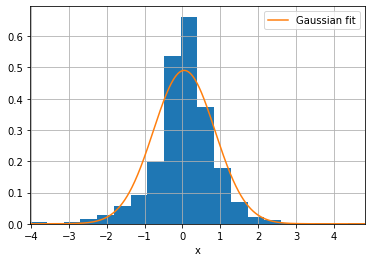

In [5992]:
# Plot histogram of the daily returns
ax = df['daily_ret'].hist(bins=20, density=True)
gauss_df.plot(x='x', y='y', grid=True, ax=ax)
plt.legend(['Gaussian fit'])

In [5993]:
fig = ff.create_distplot([np.array(df['daily_ret'][1:])], 
                         ['distplot'], 
                         bin_size=.1,
                         curve_type='normal', # override default 'kde'
                         )

# Add title
fig.update_layout(title_text='Distplot of daily returns with Normal Distribution')
fig.show()

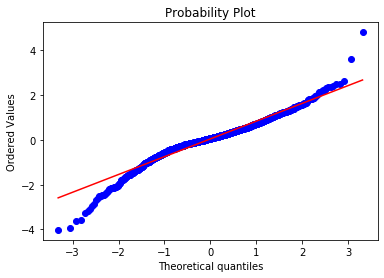

In [5994]:
# Plot QQ plot
stats.probplot(df['daily_ret'][1:], dist="norm", plot=pylab)
pylab.show()

Looks mostly Gaussian, except for the extreme values

In [5996]:
# Plot with plotly
data = [go.Scatter(
            x = df['date'],
            y = df['adj_close'],
            mode = 'lines')]

layout = dict(xaxis = dict(title = 'date'),
              yaxis = dict(title = 'USD'))

fig = dict(data=data, layout=layout)
pyo.iplot(fig, filename=filename)

# Feature Engineering

## Simple Moving Average

In [5997]:
# Simple moving average
df['sma_10'] = df['adj_close'].rolling(window = 10).mean()
df['sma_20'] = df['adj_close'].rolling(window = 20).mean()
df['sma_50'] = df['adj_close'].rolling(window = 50).mean()
df['sma_100'] = df['adj_close'].rolling(window = 100).mean()
df['sma_200'] = df['adj_close'].rolling(window = 200).mean()

# Get the sma on the previous day
df['adj_close_lag_1'] = df['adj_close'].shift(1)
df['sma_10_lag_1'] = df['sma_10'].shift(1)
df['sma_20_lag_1'] = df['sma_20'].shift(1)
df['sma_50_lag_1'] = df['sma_50'].shift(1)
df['sma_100_lag_1'] = df['sma_100'].shift(1)
df['sma_200_lag_1'] = df['sma_200'].shift(1)

# Get above signals
df['sma_above20'] = (df['adj_close'] > df['sma_20']).astype(int)
df['sma_above50'] = (df['adj_close'] > df['sma_50']).astype(int)
df['sma_above100'] = (df['adj_close'] > df['sma_100']).astype(int)
df['sma_above200'] = (df['adj_close'] > df['sma_200']).astype(int)

df['sma_10above20'] = (df['sma_10'] > df['sma_20']).astype(int)
df['sma_10above50'] = (df['sma_10'] > df['sma_50']).astype(int)
df['sma_10above100'] = (df['sma_10'] > df['sma_100']).astype(int)
df['sma_10above200'] = (df['sma_10'] > df['sma_200']).astype(int)

# Get bullish crossover signals
df['sma_cut20'] = ((df['adj_close_lag_1'] < df['sma_20_lag_1']) & (df['sma_above20']==True)).astype(int)
df['sma_cut50'] = ((df['adj_close_lag_1'] < df['sma_50_lag_1']) & (df['sma_above50']==True)).astype(int)
df['sma_cut100'] = ((df['adj_close_lag_1'] < df['sma_100_lag_1']) & (df['sma_above100']==True)).astype(int)
df['sma_cut200'] = ((df['adj_close_lag_1'] < df['sma_200_lag_1']) & (df['sma_above200']==True)).astype(int)

df['sma_10cut20'] = ((df['sma_10_lag_1'] < df['sma_20_lag_1']) & (df['sma_10above20']==True)).astype(int)
df['sma_10cut50'] = ((df['sma_10_lag_1'] < df['sma_50_lag_1']) & (df['sma_10above50']==True)).astype(int)
df['sma_10cut100'] = ((df['sma_10_lag_1'] < df['sma_100_lag_1']) & (df['sma_10above100']==True)).astype(int)
df['sma_10cut200'] = ((df['sma_10_lag_1'] < df['sma_200_lag_1']) & (df['sma_10above200']==True)).astype(int)

# Get bearish crossover signals
df['sma_cut20down'] = ((df['adj_close_lag_1'] > df['sma_20_lag_1']) & (df['adj_close'] < df['sma_20'])).astype(int)
df['sma_cut50down'] = ((df['adj_close_lag_1'] > df['sma_50_lag_1']) & (df['adj_close'] < df['sma_50'])).astype(int)
df['sma_cut100down'] = ((df['adj_close_lag_1'] > df['sma_100_lag_1']) & (df['adj_close'] < df['sma_100'])).astype(int)
df['sma_cut200down'] = ((df['adj_close_lag_1'] > df['sma_200_lag_1']) & (df['adj_close'] < df['sma_200'])).astype(int)

df['sma_10cut20down'] = ((df['sma_10_lag_1'] > df['sma_20_lag_1']) & (df['sma_10'] < df['sma_20'])).astype(int)
df['sma_10cut50down'] = ((df['sma_10_lag_1'] > df['sma_50_lag_1']) & (df['sma_10'] < df['sma_50'])).astype(int)
df['sma_10cut100down'] = ((df['sma_10_lag_1'] > df['sma_100_lag_1']) & (df['sma_10'] < df['sma_100'])).astype(int)
df['sma_10cut200down'] = ((df['sma_10_lag_1'] > df['sma_200_lag_1']) & (df['sma_10'] < df['sma_200'])).astype(int)

df[:50]

date       open       high        low      close  adj_close   volume  \
0  2013-01-02  74.529999  75.150002  74.500000  75.139999  66.997757  5037200   
1  2013-01-03  75.120003  75.370003  74.839996  75.029999  66.899689  2634600   
2  2013-01-04  75.139999  75.519997  74.989998  75.410004  67.238510  2512900   
3  2013-01-07  75.180000  75.279999  74.949997  75.209999  67.060173  2511200   
4  2013-01-08  75.110001  75.180000  74.699997  75.010002  66.881859  1407900   
5  2013-01-09  75.190002  75.410004  75.110001  75.239998  67.086937  1421900   
6  2013-01-10  75.620003  75.769997  75.220001  75.760002  67.550591  1403700   
7  2013-01-11  75.760002  75.800003  75.510002  75.769997  67.559486  1248500   
8  2013-01-14  75.750000  75.800003  75.440002  75.690002  67.488159  2745100   
9  2013-01-15  75.400002  75.889999  75.339996  75.830002  67.612984  1109100   
10 2013-01-16  75.680000  75.910004  75.589996  75.769997  67.559486  1211300   
11 2013-01-17  76.110001  76.500000  76.000000  76.290001  68.023140  1534800   
12 2013-01-18  76.320000  76.540001  76.040001  76.500000  68.210396  2173800   
13 2013-01-22  76.500000  76.900002  76.330002  76.900002  68.567047  3583900   
14 2013-01-23  76.930000  77.080002  76.779999  76.989998  68.647293  2295000   
15 2013-01-24  76.919998  77.440002  76.860001  77.080002  68.727539  5386800   
16 2013-01-25  77.379997  77.529999  77.120003  77.510002  69.110970  2997100   
17 2013-01-28  77.599998  77.610001  77.150002  77.440002  69.048531  1634100   
18 2013-01-29  77.339996  77.769997  77.239998  77.699997  69.280342  2279300   
19 2013-01-30  77.690002  77.830002  77.269997  77.389999  69.003944  2074200   
20 2013-01-31  77.330002  77.500000  77.150002  77.250000  68.879120  2611300   
21 2013-02-01  77.779999  78.110001  77.610001  78.000000  69.547852  2550000   
22 2013-02-04  77.639999  77.720001  77.129997  77.180000  68.816704  2457700   
23 2013-02-05  77.620003  78.110001  77.540001  77.910004  69.467598  1609800   
24 2013-02-06  77.680000  78.059998  77.599998  78.050003  69.592445  1739400   
25 2013-02-07  78.050003  78.129997  77.360001  77.910004  69.467598  2260100   
26 2013-02-08  78.029999  78.379997  78.010002  78.379997  69.886673  4399000   
27 2013-02-11  78.360001  78.389999  78.139999  78.339996  69.850990  2112700   
28 2013-02-12  78.339996  78.599998  78.279999  78.470001  69.966904  1568600   
29 2013-02-13  78.680000  78.790001  78.339996  78.580002  70.064987  1346500   
30 2013-02-14  78.349998  78.750000  78.279999  78.680000  70.154160  1287500   
31 2013-02-15  78.750000  78.830002  78.320000  78.589996  70.073921  1248400   
32 2013-02-19  78.709999  79.160004  78.709999  79.139999  70.564316  1763000   
33 2013-02-20  79.110001  79.129997  78.080002  78.089996  69.628090  2507600   
34 2013-02-21  77.889999  77.889999  77.250000  77.559998  69.155525  2641300   
35 2013-02-22  77.919998  78.309998  77.769997  78.309998  69.824265  1833200   
36 2013-02-25  78.680000  78.779999  76.849998  76.870003  68.540260  1979400   
37 2013-02-26  77.190002  77.440002  76.669998  77.360001  68.977203  2505700   
38 2013-02-27  77.269997  78.529999  77.260002  78.309998  69.824265  1442500   
39 2013-02-28  78.309998  78.809998  78.129997  78.239998  69.761841  1564400   
40 2013-03-01  77.959999  78.500000  77.510002  78.419998  69.922325  1884800   
41 2013-03-04  78.239998  78.779999  78.099998  78.779999  70.243340  1418100   
42 2013-03-05  79.150002  79.720001  79.099998  79.570000  70.947716  1855000   
43 2013-03-06  79.839996  79.889999  79.519997  79.690002  71.054733  2045000   
44 2013-03-07  79.800003  79.949997  79.720001  79.879997  71.224144  1564000   
45 2013-03-08  80.230003  80.360001  79.820000  80.269997  71.571861  1984200   
46 2013-03-11  80.190002  80.529999  80.089996  80.500000  71.776939  1610000   
47 2013-03-12  80.470001  80.570000  80.120003  80.360001  71.652100  1505700   
48 2013-03-13  80.370003  80.610001  80.

In [5998]:
signals = df[df['sma_10cut200']==1]

# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['sma_10'], 
                         mode='lines', 
                         name='sma_10', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['sma_20'], 
                         mode='lines', 
                         name='sma_20', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['sma_50'], 
                         mode='lines', 
                         name='sma_50', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['sma_100'], 
                         mode='lines', 
                         name='sma_100', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['sma_200'], 
                         mode='lines', 
                         name='sma_200', 
                         ))

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ))
    n = n+1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

py.iplot(fig, filename='VTI_20130102_20181231_sma')

In [5999]:
# Del unneccesary cols
df.drop(['sma_10', 'sma_50', 'sma_100', 'sma_200',
         'sma_10_lag_1', 'sma_20_lag_1', 'sma_50_lag_1', 'sma_100_lag_1', 'sma_200_lag_1'], axis=1, inplace=True)

## Exponential Moving Average

In [6000]:
# Exponential moving average
df['ema_10'] = df['adj_close'].ewm(span = 10, adjust=False).mean()
df['ema_20'] = df['adj_close'].ewm(span = 20, adjust=False).mean()
df['ema_50'] = df['adj_close'].ewm(span = 50, adjust=False).mean()
df['ema_100'] = df['adj_close'].ewm(span = 100, adjust=False).mean()
df['ema_200'] = df['adj_close'].ewm(span = 200, adjust=False).mean()

# Get the ema on the previous day
df['adj_close_lag_1'] = df['adj_close'].shift(1)
df['ema_10_lag_1'] = df['ema_10'].shift(1)
df['ema_20_lag_1'] = df['ema_20'].shift(1)
df['ema_50_lag_1'] = df['ema_50'].shift(1)
df['ema_100_lag_1'] = df['ema_100'].shift(1)
df['ema_200_lag_1'] = df['ema_200'].shift(1)

# Get above signals
df['ema_above20'] = (df['adj_close'] > df['ema_20']).astype(int)
df['ema_above50'] = (df['adj_close'] > df['ema_50']).astype(int)
df['ema_above100'] = (df['adj_close'] > df['ema_100']).astype(int)
df['ema_above200'] = (df['adj_close'] > df['ema_200']).astype(int)

df['ema_10above20'] = (df['ema_10'] > df['ema_20']).astype(int)
df['ema_10above50'] = (df['ema_10'] > df['ema_50']).astype(int)
df['ema_10above100'] = (df['ema_10'] > df['ema_100']).astype(int)
df['ema_10above200'] = (df['ema_10'] > df['ema_200']).astype(int)

# Get bullish crossover signals
df['ema_cut20'] = ((df['adj_close_lag_1'] < df['ema_20_lag_1']) & (df['ema_above20']==True)).astype(int)
df['ema_cut50'] = ((df['adj_close_lag_1'] < df['ema_50_lag_1']) & (df['ema_above50']==True)).astype(int)
df['ema_cut100'] = ((df['adj_close_lag_1'] < df['ema_100_lag_1']) & (df['ema_above100']==True)).astype(int)
df['ema_cut200'] = ((df['adj_close_lag_1'] < df['ema_200_lag_1']) & (df['ema_above200']==True)).astype(int)

df['ema_10cut20'] = ((df['ema_10_lag_1'] < df['ema_20_lag_1']) & (df['ema_10above20']==True)).astype(int)
df['ema_10cut50'] = ((df['ema_10_lag_1'] < df['ema_50_lag_1']) & (df['ema_10above50']==True)).astype(int)
df['ema_10cut100'] = ((df['ema_10_lag_1'] < df['ema_100_lag_1']) & (df['ema_10above100']==True)).astype(int)
df['ema_10cut200'] = ((df['ema_10_lag_1'] < df['ema_200_lag_1']) & (df['ema_10above200']==True)).astype(int)

# Get bearish crossover signals
df['ema_cut20down'] = ((df['adj_close_lag_1'] > df['ema_20_lag_1']) & (df['adj_close'] < df['ema_20'])).astype(int)
df['ema_cut50down'] = ((df['adj_close_lag_1'] > df['ema_50_lag_1']) & (df['adj_close'] < df['ema_50'])).astype(int)
df['ema_cut100down'] = ((df['adj_close_lag_1'] > df['ema_100_lag_1']) & (df['adj_close'] < df['ema_100'])).astype(int)
df['ema_cut200down'] = ((df['adj_close_lag_1'] > df['ema_200_lag_1']) & (df['adj_close'] < df['ema_200'])).astype(int)

df['ema_10cut20down'] = ((df['ema_10_lag_1'] > df['ema_20_lag_1']) & (df['ema_10'] < df['ema_20'])).astype(int)
df['ema_10cut50down'] = ((df['ema_10_lag_1'] > df['ema_50_lag_1']) & (df['ema_10'] < df['ema_50'])).astype(int)
df['ema_10cut100down'] = ((df['ema_10_lag_1'] > df['ema_100_lag_1']) & (df['ema_10'] < df['ema_100'])).astype(int)
df['ema_10cut200down'] = ((df['ema_10_lag_1'] > df['ema_200_lag_1']) & (df['ema_10'] < df['ema_200'])).astype(int)

df

date        open        high         low       close   adj_close  \
0    2013-01-02   74.529999   75.150002   74.500000   75.139999   66.997757   
1    2013-01-03   75.120003   75.370003   74.839996   75.029999   66.899689   
2    2013-01-04   75.139999   75.519997   74.989998   75.410004   67.238510   
3    2013-01-07   75.180000   75.279999   74.949997   75.209999   67.060173   
4    2013-01-08   75.110001   75.180000   74.699997   75.010002   66.881859   
...         ...         ...         ...         ...         ...         ...   
1504 2018-12-21  126.510002  127.970001  123.120003  123.489998  122.768997   
1505 2018-12-24  121.900002  122.540001  119.669998  119.699997  119.699997   
1506 2018-12-26  120.339996  125.519997  119.349998  125.459999  125.459999   
1507 2018-12-27  123.760002  126.589996  121.910004  126.589996  126.589996   
1508 2018-12-28  127.500000  128.309998  125.730003  126.430000  126.430000   

        volume  daily_ret      sma_20  adj_close_lag_1  ...  ema_10cut100  \
0      5037200        NaN         NaN              NaN  ...             0   
1      2634600  -0.146375         NaN        66.997757  ...             0   
2      2512900   0.506461         NaN        66.899689  ...             1   
3      2511200  -0.265230         NaN        67.238510  ...             0   
4      1407900  -0.265901         NaN        67.060173  ...             0   
...        ...        ...         ...              ...  ...           ...   
1504  13605000  -2.124119  134.177005       125.433350  ...             0   
1505  14488500  -2.499817  133.444952       122.768997  ...             0   
1506  12512300   4.812032  132.896514       119.699997  ...             0   
1507  16128500   0.900683  132.396125       125.459999  ...             0   
1508  11668700  -0.126389  131.728669       126.589996  ...             0   

      ema_10cut200  ema_cut20down  ema_cut50down  ema_cut100down  \
0                0              0              0               0   
1                0              0              0               0   
2                1              0              0               0   
3                0              0              0               0   
4                0              1              1               1   
...            ...            ...            ...             ...   
1504             0              0              0               0   
1505             0              0              0               0   
1506             0              0              0               0   
1507             0              0              0               0   
1508             0              0              0               0   

      ema_cut200down  ema_10cut20down  ema_10cut50down  ema_10cut100down  \
0                  0                0                0                 0   
1                  0                0                0                 0   
2                  0                0                0                 0   
3                  0                0                0                 0   
4                  1                0                0                 0   
...              ...              ...              ...               ...   
1504               0                0                0                 0   
1505               0                0                0                 0   
1506               0                0                0                 0   
1507               0                0                0                 0   
1508               0                0                0                 0   

      ema_10cut200down  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1504                 0  
1505                 0  
1506                 0  
1507                 0  
1508                 0  

[1509 rows x 68 columns]

In [6001]:
signals = df[df['ema_10cut200']==1]

# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['ema_10'], 
                         mode='lines', 
                         name='ema_10', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['ema_20'], 
                         mode='lines', 
                         name='ema_20', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['ema_50'], 
                         mode='lines', 
                         name='ema_50', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['ema_100'], 
                         mode='lines', 
                         name='ema_100', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['ema_200'], 
                         mode='lines', 
                         name='ema_200', 
                         ))

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ))
    n = n+1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

py.iplot(fig, filename='VTI_20130102_20181231_ema')

In [6002]:
# Del unneccesary cols
df.drop(['ema_10', 'ema_20', 'ema_50', 'ema_100', 'ema_200',
         'ema_10_lag_1', 'ema_20_lag_1', 'ema_50_lag_1', 'ema_100_lag_1', 'ema_200_lag_1'], axis=1, inplace=True)

## Moving Average Convergence Divergence

Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/m/macd.asp

In [6003]:
# Exponential moving average
df['ema_12'] = df['adj_close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['adj_close'].ewm(span=26, adjust=False).mean()

# MACD
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Get the macd on the previous day
df['macd_lag_1'] = df['macd'].shift(1)
df['macd_signal_lag_1'] = df['macd_signal'].shift(1)

# Get bullish crossover signals
df['macd_crossover'] = ((df['macd_lag_1'] < df['macd_signal_lag_1']) & \
                        (df['macd'] > df['macd_signal'])).astype(int)

# Get bearish crossover signals
df['macd_crossoverdown'] = ((df['macd_lag_1'] > df['macd_signal_lag_1']) & \
                        (df['macd'] < df['macd_signal'])).astype(int)

df

date        open        high         low       close   adj_close  \
0    2013-01-02   74.529999   75.150002   74.500000   75.139999   66.997757   
1    2013-01-03   75.120003   75.370003   74.839996   75.029999   66.899689   
2    2013-01-04   75.139999   75.519997   74.989998   75.410004   67.238510   
3    2013-01-07   75.180000   75.279999   74.949997   75.209999   67.060173   
4    2013-01-08   75.110001   75.180000   74.699997   75.010002   66.881859   
...         ...         ...         ...         ...         ...         ...   
1504 2018-12-21  126.510002  127.970001  123.120003  123.489998  122.768997   
1505 2018-12-24  121.900002  122.540001  119.669998  119.699997  119.699997   
1506 2018-12-26  120.339996  125.519997  119.349998  125.459999  125.459999   
1507 2018-12-27  123.760002  126.589996  121.910004  126.589996  126.589996   
1508 2018-12-28  127.500000  128.309998  125.730003  126.430000  126.430000   

        volume  daily_ret      sma_20  adj_close_lag_1  ...  ema_10cut100down  \
0      5037200        NaN         NaN              NaN  ...                 0   
1      2634600  -0.146375         NaN        66.997757  ...                 0   
2      2512900   0.506461         NaN        66.899689  ...                 0   
3      2511200  -0.265230         NaN        67.238510  ...                 0   
4      1407900  -0.265901         NaN        67.060173  ...                 0   
...        ...        ...         ...              ...  ...               ...   
1504  13605000  -2.124119  134.177005       125.433350  ...                 0   
1505  14488500  -2.499817  133.444952       122.768997  ...                 0   
1506  12512300   4.812032  132.896514       119.699997  ...                 0   
1507  16128500   0.900683  132.396125       125.459999  ...                 0   
1508  11668700  -0.126389  131.728669       126.589996  ...                 0   

      ema_10cut200down      ema_12      ema_26      macd  macd_signal  \
0                    0   66.997757   66.997757  0.000000     0.000000   
1                    0   66.982670   66.990493 -0.007823    -0.001565   
2                    0   67.022030   67.008864  0.013165     0.001381   
3                    0   67.027898   67.012665  0.015233     0.004152   
4                    0   67.005430   67.002976  0.002455     0.003812   
...                ...         ...         ...       ...          ...   
1504                 0  130.364140  133.743053 -3.378913    -2.170549   
1505                 0  128.723503  132.702827 -3.979324    -2.532304   
1506                 0  128.221425  132.166321 -3.944896    -2.814823   
1507                 0  127.970436  131.753260 -3.782824    -3.008423   
1508                 0  127.733446  131.358945 -3.625499    -3.131838   

      macd_lag_1  macd_signal_lag_1  macd_crossover  macd_crossoverdown  
0            NaN                NaN               0                   0  
1       0.000000           0.000000               0                   0  
2      -0.007823          -0.001565               1                   0  
3       0.013165           0.001381               0                   0  
4       0.015233           0.004152               0                   1  
...          ...                ...             ...                 ...  
1504   -2.875903          -1.868458               0                   0  
1505   -3.378913          -2.170549               0                   0  
1506   -3.979324          -2.532304               0                   0  
1507   -3.944896          -2.814823               0                   0  
1508   -3.782824          -3.008423               0                   0  

[1509 rows x 66 columns]

In [6004]:
signals = df[df['macd_crossover']==1]

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['ema_12'], 
                         mode='lines', 
                         name='ema_12', 
                         ), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['ema_26'], 
                         mode='lines', 
                         name='ema_26', 
                         ), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['macd'], 
                         mode='lines', 
                         name='macd', 
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['macd_signal'], 
                         mode='lines', 
                         name='macd_signal', 
                         ), row=2, col=1)

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ), row=1, col=1)
    n = n+1

fig.update_layout(yaxis=dict(title='USD'))
fig.update_xaxes(title_text="date", row=2, col=1)

py.iplot(fig, filename='VTI_20130102_20181231_macd')

In [6005]:
# Del unneccesary cols
df.drop(['ema_12', 'ema_26', 'macd_signal', 'macd_lag_1', 'macd_signal_lag_1'], axis=1, inplace=True)

## Stochastic Oscillator
Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/s/stochasticoscillator.asp#:~:text=A%20stochastic%20oscillator%20is%20a,moving%20average%20of%20the%20result.

In [6006]:
# Generate fast and slow stochastic oscillators
df['lowest_14'] = df['close'].rolling(window = 14).min()
df['highest_14'] = df['close'].rolling(window = 14).max()
df['stochastic_fast'] = 100.0*(df['close'] - df['lowest_14'])/(df['highest_14'] - df['lowest_14'])
df['stochastic_slow'] = df['stochastic_fast'].rolling(window = 3).mean()

# Get the stochastics on the previous day
df['stochastic_fast_lag_1'] = df['stochastic_fast'].shift(1)
df['stochastic_slow_lag_1'] = df['stochastic_slow'].shift(1)

# Get bullish crossover signals
df['stochastic_fastcutslow'] = ((df['stochastic_fast_lag_1'] < df['stochastic_slow_lag_1']) & \
                                (df['stochastic_fast'] > df['stochastic_slow'])).astype(int)

# Get bearish crossover signals
df['stochastic_fastcutslowdown'] = ((df['stochastic_fast_lag_1'] > df['stochastic_slow_lag_1']) & \
                                (df['stochastic_fast'] < df['stochastic_slow'])).astype(int)

# Get overbought/oversold signals
df['stochastic_overs'] = (df['stochastic_fast'] < 20).astype(int)
df['stochastic_overb'] = (df['stochastic_fast'] > 80).astype(int)

df[:50]

date       open       high        low      close  adj_close   volume  \
0  2013-01-02  74.529999  75.150002  74.500000  75.139999  66.997757  5037200   
1  2013-01-03  75.120003  75.370003  74.839996  75.029999  66.899689  2634600   
2  2013-01-04  75.139999  75.519997  74.989998  75.410004  67.238510  2512900   
3  2013-01-07  75.180000  75.279999  74.949997  75.209999  67.060173  2511200   
4  2013-01-08  75.110001  75.180000  74.699997  75.010002  66.881859  1407900   
5  2013-01-09  75.190002  75.410004  75.110001  75.239998  67.086937  1421900   
6  2013-01-10  75.620003  75.769997  75.220001  75.760002  67.550591  1403700   
7  2013-01-11  75.760002  75.800003  75.510002  75.769997  67.559486  1248500   
8  2013-01-14  75.750000  75.800003  75.440002  75.690002  67.488159  2745100   
9  2013-01-15  75.400002  75.889999  75.339996  75.830002  67.612984  1109100   
10 2013-01-16  75.680000  75.910004  75.589996  75.769997  67.559486  1211300   
11 2013-01-17  76.110001  76.500000  76.000000  76.290001  68.023140  1534800   
12 2013-01-18  76.320000  76.540001  76.040001  76.500000  68.210396  2173800   
13 2013-01-22  76.500000  76.900002  76.330002  76.900002  68.567047  3583900   
14 2013-01-23  76.930000  77.080002  76.779999  76.989998  68.647293  2295000   
15 2013-01-24  76.919998  77.440002  76.860001  77.080002  68.727539  5386800   
16 2013-01-25  77.379997  77.529999  77.120003  77.510002  69.110970  2997100   
17 2013-01-28  77.599998  77.610001  77.150002  77.440002  69.048531  1634100   
18 2013-01-29  77.339996  77.769997  77.239998  77.699997  69.280342  2279300   
19 2013-01-30  77.690002  77.830002  77.269997  77.389999  69.003944  2074200   
20 2013-01-31  77.330002  77.500000  77.150002  77.250000  68.879120  2611300   
21 2013-02-01  77.779999  78.110001  77.610001  78.000000  69.547852  2550000   
22 2013-02-04  77.639999  77.720001  77.129997  77.180000  68.816704  2457700   
23 2013-02-05  77.620003  78.110001  77.540001  77.910004  69.467598  1609800   
24 2013-02-06  77.680000  78.059998  77.599998  78.050003  69.592445  1739400   
25 2013-02-07  78.050003  78.129997  77.360001  77.910004  69.467598  2260100   
26 2013-02-08  78.029999  78.379997  78.010002  78.379997  69.886673  4399000   
27 2013-02-11  78.360001  78.389999  78.139999  78.339996  69.850990  2112700   
28 2013-02-12  78.339996  78.599998  78.279999  78.470001  69.966904  1568600   
29 2013-02-13  78.680000  78.790001  78.339996  78.580002  70.064987  1346500   
30 2013-02-14  78.349998  78.750000  78.279999  78.680000  70.154160  1287500   
31 2013-02-15  78.750000  78.830002  78.320000  78.589996  70.073921  1248400   
32 2013-02-19  78.709999  79.160004  78.709999  79.139999  70.564316  1763000   
33 2013-02-20  79.110001  79.129997  78.080002  78.089996  69.628090  2507600   
34 2013-02-21  77.889999  77.889999  77.250000  77.559998  69.155525  2641300   
35 2013-02-22  77.919998  78.309998  77.769997  78.309998  69.824265  1833200   
36 2013-02-25  78.680000  78.779999  76.849998  76.870003  68.540260  1979400   
37 2013-02-26  77.190002  77.440002  76.669998  77.360001  68.977203  2505700   
38 2013-02-27  77.269997  78.529999  77.260002  78.309998  69.824265  1442500   
39 2013-02-28  78.309998  78.809998  78.129997  78.239998  69.761841  1564400   
40 2013-03-01  77.959999  78.500000  77.510002  78.419998  69.922325  1884800   
41 2013-03-04  78.239998  78.779999  78.099998  78.779999  70.243340  1418100   
42 2013-03-05  79.150002  79.720001  79.099998  79.570000  70.947716  1855000   
43 2013-03-06  79.839996  79.889999  79.519997  79.690002  71.054733  2045000   
44 2013-03-07  79.800003  79.949997  79.720001  79.879997  71.224144  1564000   
45 2013-03-08  80.230003  80.360001  79.820000  80.269997  71.571861  1984200   
46 2013-03-11  80.190002  80.529999  80.089996  80.500000  71.776939  1610000   
47 2013-03-12  80.470001  80.570000  80.120003  80.360001  71.652100  1505700   
48 2013-03-13  80.370003  80.610001  80.

In [6007]:
signals = df[df['stochastic_fastcutslow']==1]

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['stochastic_fast'], 
                         mode='lines', 
                         name='stochastic_fast', 
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['stochastic_slow'], 
                         mode='lines', 
                         name='stochastic_fast', 
                         ), row=2, col=1)

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ), row=1, col=1)
    n = n+1

fig.update_layout(yaxis=dict(title='USD'))
fig.update_xaxes(title_text="date", row=2, col=1)

py.iplot(fig, filename='VTI_20130102_20181231_stochastic_osc')

In [6008]:
signals = df[df['stochastic_overs']==True]

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['stochastic_fast'], 
                         mode='lines', 
                         name='stochastic_fast', 
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=[20]*len(df['date']), 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dash'),
                         showlegend=False
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=[80]*len(df['date']), 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dash'),
                         showlegend=False
                         ), row=2, col=1)

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ), row=1, col=1)
    n = n+1

fig.update_layout(yaxis=dict(title='USD'))
fig.update_xaxes(title_text="date", row=2, col=1)

py.iplot(fig, filename='VTI_20130102_20181231_stochastic_osc_obos')

In [6009]:
# Del unneccesary cols
df.drop(['lowest_14', 
         'highest_14', 
         'stochastic_fast_lag_1', 
         'stochastic_slow_lag_1'], axis=1, inplace=True)

## Relative Strength Index
Implemented according to:

https://www.investopedia.com/terms/r/rsi.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi

In [6010]:
# Get gain and loss columns
df['gain'] = df['daily_ret']
df.loc[df['gain']<0, 'gain'] = 0

df['loss'] = df['daily_ret']
df.loc[df['loss']>0, 'loss'] = 0
df['loss'] = abs(df['loss'])

# Get avg_gain, avg_loss columns
df['avg_gain'] = df['gain'].rolling(window = 14).mean()
df['avg_loss'] = df['loss'].rolling(window = 14).mean()

for index, row in df[15:].iterrows():
    df.loc[index, 'avg_gain'] = (df.loc[index-1, 'avg_gain']*13 + row['gain'])/14
    df.loc[index, 'avg_loss'] = (df.loc[index-1, 'avg_loss']*13 + row['loss'])/14
    
# Calc RSI
df['rsi'] = 100 - 100/(1+(df['avg_gain']/df['avg_loss']))
df['rsi_ob'] = (df['rsi'] > 70).astype(int)
df['rsi_os'] = (df['rsi'] < 30).astype(int)

df[:50]

date       open       high        low      close  adj_close   volume  \
0  2013-01-02  74.529999  75.150002  74.500000  75.139999  66.997757  5037200   
1  2013-01-03  75.120003  75.370003  74.839996  75.029999  66.899689  2634600   
2  2013-01-04  75.139999  75.519997  74.989998  75.410004  67.238510  2512900   
3  2013-01-07  75.180000  75.279999  74.949997  75.209999  67.060173  2511200   
4  2013-01-08  75.110001  75.180000  74.699997  75.010002  66.881859  1407900   
5  2013-01-09  75.190002  75.410004  75.110001  75.239998  67.086937  1421900   
6  2013-01-10  75.620003  75.769997  75.220001  75.760002  67.550591  1403700   
7  2013-01-11  75.760002  75.800003  75.510002  75.769997  67.559486  1248500   
8  2013-01-14  75.750000  75.800003  75.440002  75.690002  67.488159  2745100   
9  2013-01-15  75.400002  75.889999  75.339996  75.830002  67.612984  1109100   
10 2013-01-16  75.680000  75.910004  75.589996  75.769997  67.559486  1211300   
11 2013-01-17  76.110001  76.500000  76.000000  76.290001  68.023140  1534800   
12 2013-01-18  76.320000  76.540001  76.040001  76.500000  68.210396  2173800   
13 2013-01-22  76.500000  76.900002  76.330002  76.900002  68.567047  3583900   
14 2013-01-23  76.930000  77.080002  76.779999  76.989998  68.647293  2295000   
15 2013-01-24  76.919998  77.440002  76.860001  77.080002  68.727539  5386800   
16 2013-01-25  77.379997  77.529999  77.120003  77.510002  69.110970  2997100   
17 2013-01-28  77.599998  77.610001  77.150002  77.440002  69.048531  1634100   
18 2013-01-29  77.339996  77.769997  77.239998  77.699997  69.280342  2279300   
19 2013-01-30  77.690002  77.830002  77.269997  77.389999  69.003944  2074200   
20 2013-01-31  77.330002  77.500000  77.150002  77.250000  68.879120  2611300   
21 2013-02-01  77.779999  78.110001  77.610001  78.000000  69.547852  2550000   
22 2013-02-04  77.639999  77.720001  77.129997  77.180000  68.816704  2457700   
23 2013-02-05  77.620003  78.110001  77.540001  77.910004  69.467598  1609800   
24 2013-02-06  77.680000  78.059998  77.599998  78.050003  69.592445  1739400   
25 2013-02-07  78.050003  78.129997  77.360001  77.910004  69.467598  2260100   
26 2013-02-08  78.029999  78.379997  78.010002  78.379997  69.886673  4399000   
27 2013-02-11  78.360001  78.389999  78.139999  78.339996  69.850990  2112700   
28 2013-02-12  78.339996  78.599998  78.279999  78.470001  69.966904  1568600   
29 2013-02-13  78.680000  78.790001  78.339996  78.580002  70.064987  1346500   
30 2013-02-14  78.349998  78.750000  78.279999  78.680000  70.154160  1287500   
31 2013-02-15  78.750000  78.830002  78.320000  78.589996  70.073921  1248400   
32 2013-02-19  78.709999  79.160004  78.709999  79.139999  70.564316  1763000   
33 2013-02-20  79.110001  79.129997  78.080002  78.089996  69.628090  2507600   
34 2013-02-21  77.889999  77.889999  77.250000  77.559998  69.155525  2641300   
35 2013-02-22  77.919998  78.309998  77.769997  78.309998  69.824265  1833200   
36 2013-02-25  78.680000  78.779999  76.849998  76.870003  68.540260  1979400   
37 2013-02-26  77.190002  77.440002  76.669998  77.360001  68.977203  2505700   
38 2013-02-27  77.269997  78.529999  77.260002  78.309998  69.824265  1442500   
39 2013-02-28  78.309998  78.809998  78.129997  78.239998  69.761841  1564400   
40 2013-03-01  77.959999  78.500000  77.510002  78.419998  69.922325  1884800   
41 2013-03-04  78.239998  78.779999  78.099998  78.779999  70.243340  1418100   
42 2013-03-05  79.150002  79.720001  79.099998  79.570000  70.947716  1855000   
43 2013-03-06  79.839996  79.889999  79.519997  79.690002  71.054733  2045000   
44 2013-03-07  79.800003  79.949997  79.720001  79.879997  71.224144  1564000   
45 2013-03-08  80.230003  80.360001  79.820000  80.269997  71.571861  1984200   
46 2013-03-11  80.190002  80.529999  80.089996  80.500000  71.776939  1610000   
47 2013-03-12  80.470001  80.570000  80.120003  80.360001  71.652100  1505700   
48 2013-03-13  80.370003  80.610001  80.

In [6011]:
signals = df[df['rsi_os']==1]

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['rsi'], 
                         mode='lines', 
                         name='rsi', 
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=[30]*len(df['date']), 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dash'),
                         showlegend=False
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=[70]*len(df['date']), 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dash'),
                         showlegend=False
                         ), row=2, col=1)

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ), row=1, col=1)
    n = n+1

fig.update_layout(yaxis=dict(title='USD'))
fig.update_xaxes(title_text="date", row=2, col=1)

py.iplot(fig, filename='VTI_20130102_20181231_rsi')

In [6012]:
# Del unneccesary cols
df.drop(['gain', 
         'loss'
        ], axis=1, inplace=True)

## Average True Range
Implemented according to the definition in Investopedia: https://www.investopedia.com/terms/a/atr.asp

In [6013]:
# Get atr
df['close_lag_1'] = df['close'].shift(1)
df['tr'] = np.maximum(df['high']-df['low'], np.maximum(abs(df['high']-df['close_lag_1']), abs(df['low']-df['close_lag_1'])))
df['atr'] = df['tr'].rolling(window = 14).mean()

# Get bullish atr signal - buy when next day's price is above yesterday's closing + atr
df['atr_signal'] = (df['high'] > ((df['close_lag_1'] + df['atr']))).astype(int)

# Get bearish atr signal - sell when next day's price is below yesterday's closing - atr
df['atr_signaldown'] = (df['low'] < ((df['close_lag_1'] - df['atr']))).astype(int)

df

date        open        high         low       close   adj_close  \
0    2013-01-02   74.529999   75.150002   74.500000   75.139999   66.997757   
1    2013-01-03   75.120003   75.370003   74.839996   75.029999   66.899689   
2    2013-01-04   75.139999   75.519997   74.989998   75.410004   67.238510   
3    2013-01-07   75.180000   75.279999   74.949997   75.209999   67.060173   
4    2013-01-08   75.110001   75.180000   74.699997   75.010002   66.881859   
...         ...         ...         ...         ...         ...         ...   
1504 2018-12-21  126.510002  127.970001  123.120003  123.489998  122.768997   
1505 2018-12-24  121.900002  122.540001  119.669998  119.699997  119.699997   
1506 2018-12-26  120.339996  125.519997  119.349998  125.459999  125.459999   
1507 2018-12-27  123.760002  126.589996  121.910004  126.589996  126.589996   
1508 2018-12-28  127.500000  128.309998  125.730003  126.430000  126.430000   

        volume  daily_ret      sma_20  adj_close_lag_1  ...  avg_gain  \
0      5037200        NaN         NaN              NaN  ...       NaN   
1      2634600  -0.146375         NaN        66.997757  ...       NaN   
2      2512900   0.506461         NaN        66.899689  ...       NaN   
3      2511200  -0.265230         NaN        67.238510  ...       NaN   
4      1407900  -0.265901         NaN        67.060173  ...       NaN   
...        ...        ...         ...              ...  ...       ...   
1504  13605000  -2.124119  134.177005       125.433350  ...  0.246247   
1505  14488500  -2.499817  133.444952       122.768997  ...  0.228658   
1506  12512300   4.812032  132.896514       119.699997  ...  0.556042   
1507  16128500   0.900683  132.396125       125.459999  ...  0.580659   
1508  11668700  -0.126389  131.728669       126.589996  ...  0.539184   

      avg_loss        rsi  rsi_ob  rsi_os  close_lag_1        tr       atr  \
0          NaN        NaN       0       0          NaN       NaN       NaN   
1          NaN        NaN       0       0    75.139999  0.530007       NaN   
2          NaN        NaN       0       0    75.029999  0.529999       NaN   
3          NaN        NaN       0       0    75.410004  0.460007       NaN   
4          NaN        NaN       0       0    75.209999  0.510002       NaN   
...        ...        ...     ...     ...          ...       ...       ...   
1504  0.896419  21.550233       0       1   126.169998  4.849998  3.462857   
1505  1.010948  18.446042       0       1   123.489998  3.820000  3.546429   
1506  0.938737  37.198941       0       0   119.699997  6.169999  3.637144   
1507  0.871685  39.980841       0       0   125.459999  4.679992  3.687144   
1508  0.818449  39.714982       0       0   126.589996  2.579995  3.554286   

      atr_signal  atr_signaldown  
0              0               0  
1              0               0  
2              0               0  
3              0               0  
4              0               0  
...          ...             ...  
1504           0               0  
1505           0               1  
1506           1               0  
1507           0               0  
1508           0               0  

[1509 rows x 77 columns]

In [6014]:
signals = df[df['atr_signal']==1]

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['atr'], 
                         mode='lines', 
                         name='atr', 
                         ), row=2, col=1)

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ), row=1, col=1)
    n = n+1

fig.update_layout(yaxis=dict(title='USD'))
fig.update_xaxes(title_text="date", row=2, col=1)

py.iplot(fig, filename='VTI_20130102_20181231_atr')

In [6015]:
# Del unneccesary cols
df.drop(['close_lag_1'], axis=1, inplace=True)  

## Average Directional Index
Implemented according to:

https://www.investopedia.com/terms/a/adx.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:average_directional_index_adx

In [6016]:
# Get +/- directional movement
df['high_lag_1'] = df['high'].shift(1)
df['low_lag_1'] = df['low'].shift(1)

def comp_pdm(high, high_lag_1, low, low_lag_1):
    if (high-high_lag_1) > (low_lag_1-low):
        return(max(high-high_lag_1, 0))
    else:
        return 0
    
df['+dm'] = df.apply(lambda row: comp_pdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)
    
def comp_mdm(high, high_lag_1, low, low_lag_1):
    if (low_lag_1-low) > (high-high_lag_1):
        return(max(low_lag_1-low, 0))
    else:
        return 0

df['-dm'] = df.apply(lambda row: comp_mdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)
    
    
# Get smoothed +/- directional movement
df['smoothed+dm'] = 0
df.loc[14, 'smoothed+dm'] = df[1:15]['+dm'].sum()

df['smoothed-dm'] = 0
df.loc[14, 'smoothed-dm'] = df[1:15]['-dm'].sum()

df['14tr'] = 0
df.loc[14, '14tr'] = df[1:15]['tr'].sum()

for index, row in df[15:].iterrows():
    df.loc[index, 'smoothed+dm'] = df.loc[index-1, 'smoothed+dm'] - (df.loc[index-1, 'smoothed+dm']/14) + row['+dm']
    df.loc[index, 'smoothed-dm'] = df.loc[index-1, 'smoothed-dm'] - (df.loc[index-1, 'smoothed-dm']/14) + row['-dm']
    df.loc[index, '14tr'] = df.loc[index-1, '14tr'] - (df.loc[index-1, '14tr']/14) + row['tr']
    
# Get +/- directional index
df['+di'] = 100.0*(df['smoothed+dm']/df['14tr'])
df['-di'] = 100.0*(df['smoothed-dm']/df['14tr'])

# Get directional movement index
df['dx'] = 100.0 * (abs(df['+di']-df['-di'])/abs(df['+di']+df['-di']))

# Get average directional movement index
df.loc[27, 'adx'] = df[14:28]['dx'].mean()
for index, row in df[28:].iterrows():
    df.loc[index, 'adx'] = (df.loc[index-1, 'adx']*13 + row['dx'])/14
    
# Get adx strength and trendless
df['adx_strength'] = (df['adx'] > 25).astype(int)
df['adx_trendless'] = (df['adx'] < 20).astype(int)

# Get adx signals
df['+di_lag_1'] = df['+di'].shift(1)
df['-di_lag_1'] = df['-di'].shift(1)
df['adx_bull'] = ((df['+di_lag_1'] < df['-di_lag_1']) & (df['+di'] > df['-di']) & (df['adx_strength']==True)).astype(int)
df['adx_bear'] = ((df['-di_lag_1'] < df['+di_lag_1']) & (df['-di'] > df['+di']) & (df['adx_strength']==True)).astype(int)

df[:50]

date       open       high        low      close  adj_close   volume  \
0  2013-01-02  74.529999  75.150002  74.500000  75.139999  66.997757  5037200   
1  2013-01-03  75.120003  75.370003  74.839996  75.029999  66.899689  2634600   
2  2013-01-04  75.139999  75.519997  74.989998  75.410004  67.238510  2512900   
3  2013-01-07  75.180000  75.279999  74.949997  75.209999  67.060173  2511200   
4  2013-01-08  75.110001  75.180000  74.699997  75.010002  66.881859  1407900   
5  2013-01-09  75.190002  75.410004  75.110001  75.239998  67.086937  1421900   
6  2013-01-10  75.620003  75.769997  75.220001  75.760002  67.550591  1403700   
7  2013-01-11  75.760002  75.800003  75.510002  75.769997  67.559486  1248500   
8  2013-01-14  75.750000  75.800003  75.440002  75.690002  67.488159  2745100   
9  2013-01-15  75.400002  75.889999  75.339996  75.830002  67.612984  1109100   
10 2013-01-16  75.680000  75.910004  75.589996  75.769997  67.559486  1211300   
11 2013-01-17  76.110001  76.500000  76.000000  76.290001  68.023140  1534800   
12 2013-01-18  76.320000  76.540001  76.040001  76.500000  68.210396  2173800   
13 2013-01-22  76.500000  76.900002  76.330002  76.900002  68.567047  3583900   
14 2013-01-23  76.930000  77.080002  76.779999  76.989998  68.647293  2295000   
15 2013-01-24  76.919998  77.440002  76.860001  77.080002  68.727539  5386800   
16 2013-01-25  77.379997  77.529999  77.120003  77.510002  69.110970  2997100   
17 2013-01-28  77.599998  77.610001  77.150002  77.440002  69.048531  1634100   
18 2013-01-29  77.339996  77.769997  77.239998  77.699997  69.280342  2279300   
19 2013-01-30  77.690002  77.830002  77.269997  77.389999  69.003944  2074200   
20 2013-01-31  77.330002  77.500000  77.150002  77.250000  68.879120  2611300   
21 2013-02-01  77.779999  78.110001  77.610001  78.000000  69.547852  2550000   
22 2013-02-04  77.639999  77.720001  77.129997  77.180000  68.816704  2457700   
23 2013-02-05  77.620003  78.110001  77.540001  77.910004  69.467598  1609800   
24 2013-02-06  77.680000  78.059998  77.599998  78.050003  69.592445  1739400   
25 2013-02-07  78.050003  78.129997  77.360001  77.910004  69.467598  2260100   
26 2013-02-08  78.029999  78.379997  78.010002  78.379997  69.886673  4399000   
27 2013-02-11  78.360001  78.389999  78.139999  78.339996  69.850990  2112700   
28 2013-02-12  78.339996  78.599998  78.279999  78.470001  69.966904  1568600   
29 2013-02-13  78.680000  78.790001  78.339996  78.580002  70.064987  1346500   
30 2013-02-14  78.349998  78.750000  78.279999  78.680000  70.154160  1287500   
31 2013-02-15  78.750000  78.830002  78.320000  78.589996  70.073921  1248400   
32 2013-02-19  78.709999  79.160004  78.709999  79.139999  70.564316  1763000   
33 2013-02-20  79.110001  79.129997  78.080002  78.089996  69.628090  2507600   
34 2013-02-21  77.889999  77.889999  77.250000  77.559998  69.155525  2641300   
35 2013-02-22  77.919998  78.309998  77.769997  78.309998  69.824265  1833200   
36 2013-02-25  78.680000  78.779999  76.849998  76.870003  68.540260  1979400   
37 2013-02-26  77.190002  77.440002  76.669998  77.360001  68.977203  2505700   
38 2013-02-27  77.269997  78.529999  77.260002  78.309998  69.824265  1442500   
39 2013-02-28  78.309998  78.809998  78.129997  78.239998  69.761841  1564400   
40 2013-03-01  77.959999  78.500000  77.510002  78.419998  69.922325  1884800   
41 2013-03-04  78.239998  78.779999  78.099998  78.779999  70.243340  1418100   
42 2013-03-05  79.150002  79.720001  79.099998  79.570000  70.947716  1855000   
43 2013-03-06  79.839996  79.889999  79.519997  79.690002  71.054733  2045000   
44 2013-03-07  79.800003  79.949997  79.720001  79.879997  71.224144  1564000   
45 2013-03-08  80.230003  80.360001  79.820000  80.269997  71.571861  1984200   
46 2013-03-11  80.190002  80.529999  80.089996  80.500000  71.776939  1610000   
47 2013-03-12  80.470001  80.570000  80.120003  80.360001  71.652100  1505700   
48 2013-03-13  80.370003  80.610001  80.

In [6017]:
signals = df[df['adx_bull']==1]

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adx'], 
                         mode='lines', 
                         name='adx', 
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=[20]*len(df['date']), 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dash'),
                         showlegend=False
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=[25]*len(df['date']), 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dash'),
                         showlegend=False
                         ), row=2, col=1)

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ), row=1, col=1)
    n = n+1

fig.update_layout(yaxis=dict(title='USD'))
fig.update_xaxes(title_text="date", row=2, col=1)

py.iplot(fig, filename='VTI_20130102_20181231_adx')

In [6018]:
# Del unneccesary cols
df.drop(['+di',
         '-di',
         '+di_lag_1',
         '-di_lag_1',
         'tr', 
         '+dm', 
         '-dm', 
         'smoothed+dm',
         'smoothed-dm',
         '14tr',
         'dx',
         'tr'], axis=1, inplace=True)

## Bollinger Bands

In [6019]:
df['std_20'] = df['adj_close'].rolling(window = 20).std()
df['bollinger_upp'] = df['sma_20'] + 2*df['std_20']
df['bollinger_low'] = df['sma_20'] - 2*df['std_20']

# Get dist between bollinger bands and the price
df['bollinger_upp_dist'] = df['bollinger_upp'] - df['adj_close']
df['bollinger_low_dist'] = df['adj_close'] - df['bollinger_low']

# Get signals
df['bollinger_ob'] = (df['adj_close'] > df['bollinger_upp']).astype(int)
df['bollinger_os'] = (df['adj_close'] < df['bollinger_low']).astype(int)

df

date        open        high         low       close   adj_close  \
0    2013-01-02   74.529999   75.150002   74.500000   75.139999   66.997757   
1    2013-01-03   75.120003   75.370003   74.839996   75.029999   66.899689   
2    2013-01-04   75.139999   75.519997   74.989998   75.410004   67.238510   
3    2013-01-07   75.180000   75.279999   74.949997   75.209999   67.060173   
4    2013-01-08   75.110001   75.180000   74.699997   75.010002   66.881859   
...         ...         ...         ...         ...         ...         ...   
1504 2018-12-21  126.510002  127.970001  123.120003  123.489998  122.768997   
1505 2018-12-24  121.900002  122.540001  119.669998  119.699997  119.699997   
1506 2018-12-26  120.339996  125.519997  119.349998  125.459999  125.459999   
1507 2018-12-27  123.760002  126.589996  121.910004  126.589996  126.589996   
1508 2018-12-28  127.500000  128.309998  125.730003  126.430000  126.430000   

        volume  daily_ret      sma_20  adj_close_lag_1  ...  adx_trendless  \
0      5037200        NaN         NaN              NaN  ...              0   
1      2634600  -0.146375         NaN        66.997757  ...              0   
2      2512900   0.506461         NaN        66.899689  ...              0   
3      2511200  -0.265230         NaN        67.238510  ...              0   
4      1407900  -0.265901         NaN        67.060173  ...              0   
...        ...        ...         ...              ...  ...            ...   
1504  13605000  -2.124119  134.177005       125.433350  ...              0   
1505  14488500  -2.499817  133.444952       122.768997  ...              0   
1506  12512300   4.812032  132.896514       119.699997  ...              0   
1507  16128500   0.900683  132.396125       125.459999  ...              0   
1508  11668700  -0.126389  131.728669       126.589996  ...              0   

      adx_bull  adx_bear    std_20  bollinger_upp  bollinger_low  \
0            0         0       NaN            NaN            NaN   
1            0         0       NaN            NaN            NaN   
2            0         0       NaN            NaN            NaN   
3            0         0       NaN            NaN            NaN   
4            0         0       NaN            NaN            NaN   
...        ...       ...       ...            ...            ...   
1504         0         0  5.107400     144.391805     123.962205   
1505         0         0  6.045720     145.536393     121.353511   
1506         0         0  6.254702     145.405917     120.387110   
1507         0         0  6.342711     145.081546     119.710703   
1508         0         0  6.226200     144.181069     119.276269   

      bollinger_upp_dist  bollinger_low_dist  bollinger_ob  bollinger_os  
0                    NaN                 NaN             0             0  
1                    NaN                 NaN             0             0  
2                    NaN                 NaN             0             0  
3                    NaN                 NaN             0             0  
4                    NaN                 NaN             0             0  
...                  ...                 ...           ...           ...  
1504           21.622808           -1.193208             0             1  
1505           25.836396           -1.653514             0             1  
1506           19.945918            5.072889             0             0  
1507           18.491550            6.879293             0             0  
1508           17.751069            7.153731             0             0  

[1509 rows x 89 columns]

In [6020]:
signals = df[df['bollinger_os']==True]

# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['bollinger_upp'], 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dot'),
                         name='bollinger_upp', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['bollinger_low'], 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dot'),
                         name='bollinger_low', 
                         ))
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['sma_20'], 
                         mode='lines', 
                         name='sma_20', 
                         ))

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ))
    n = n+1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

py.iplot(fig, filename='VTI_20130102_20181231_bollinger')

In [6021]:
# Del unneccesary cols
df.drop(['std_20', 'bollinger_upp', 'bollinger_low'], axis=1, inplace=True)

In [6022]:
# Check if all signals true on any day
df[(df['macd_crossover']==1) & 
   (df['stochastic_fastcutslow']==1) &
   (df['atr_signal']==1) & 
   (df['adx_bull']==1)]

Empty DataFrame
Columns: [date, open, high, low, close, adj_close, volume, daily_ret, sma_20, adj_close_lag_1, sma_above20, sma_above50, sma_above100, sma_above200, sma_10above20, sma_10above50, sma_10above100, sma_10above200, sma_cut20, sma_cut50, sma_cut100, sma_cut200, sma_10cut20, sma_10cut50, sma_10cut100, sma_10cut200, sma_cut20down, sma_cut50down, sma_cut100down, sma_cut200down, sma_10cut20down, sma_10cut50down, sma_10cut100down, sma_10cut200down, ema_above20, ema_above50, ema_above100, ema_above200, ema_10above20, ema_10above50, ema_10above100, ema_10above200, ema_cut20, ema_cut50, ema_cut100, ema_cut200, ema_10cut20, ema_10cut50, ema_10cut100, ema_10cut200, ema_cut20down, ema_cut50down, ema_cut100down, ema_cut200down, ema_10cut20down, ema_10cut50down, ema_10cut100down, ema_10cut200down, macd, macd_crossover, macd_crossoverdown, stochastic_fast, stochastic_slow, stochastic_fastcutslow, stochastic_fastcutslowdown, stochastic_overs, stochastic_overb, avg_gain, avg_loss, rsi, rsi_ob, rsi_os, atr, atr_signal, atr_signaldown, high_lag_1, low_lag_1, adx, adx_strength, adx_trendless, adx_bull, adx_bear, bollinger_upp_dist, bollinger_low_dist, bollinger_ob, bollinger_os]
Index: []

[0 rows x 86 columns]

In [6023]:
# Remove unnecessary cols
df.drop(['open',
         'high', 
         'low',
         'close',
         'volume',
         'sma_20',
         'adj_close_lag_1',
         'high_lag_1',
         'low_lag_1',
         ], axis=1, inplace=True)

In [6024]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1509 entries, 0 to 1508
Data columns (total 77 columns):
date                          1509 non-null datetime64[ns]
adj_close                     1509 non-null float64
daily_ret                     1508 non-null float64
sma_above20                   1509 non-null int64
sma_above50                   1509 non-null int64
sma_above100                  1509 non-null int64
sma_above200                  1509 non-null int64
sma_10above20                 1509 non-null int64
sma_10above50                 1509 non-null int64
sma_10above100                1509 non-null int64
sma_10above200                1509 non-null int64
sma_cut20                     1509 non-null int64
sma_cut50                     1509 non-null int64
sma_cut100                    1509 non-null int64
sma_cut200                    1509 non-null int64
sma_10cut20                   1509 non-null int64
sma_10cut50                   1509 non-null int64
sma_10cut100                  

# EDA

In [6025]:
# Count number of nulls for each column
df.isnull().sum(axis=0)

date                   0
adj_close              0
daily_ret              1
sma_above20            0
sma_above50            0
                      ..
adx_bear               0
bollinger_upp_dist    19
bollinger_low_dist    19
bollinger_ob           0
bollinger_os           0
Length: 77, dtype: int64

In [6026]:
# Create lags 
df_lags = add_lags(df, N, ['daily_ret'])
df_lags

date   adj_close  daily_ret  sma_above20  sma_above50  \
0    2013-01-02   66.997757        NaN            0            0   
1    2013-01-03   66.899689  -0.146375            0            0   
2    2013-01-04   67.238510   0.506461            0            0   
3    2013-01-07   67.060173  -0.265230            0            0   
4    2013-01-08   66.881859  -0.265901            0            0   
...         ...         ...        ...          ...          ...   
1504 2018-12-21  122.768997  -2.124119            0            0   
1505 2018-12-24  119.699997  -2.499817            0            0   
1506 2018-12-26  125.459999   4.812032            0            0   
1507 2018-12-27  126.589996   0.900683            0            0   
1508 2018-12-28  126.430000  -0.126389            0            0   

      sma_above100  sma_above200  sma_10above20  sma_10above50  \
0                0             0              0              0   
1                0             0              0              0   
2                0             0              0              0   
3                0             0              0              0   
4                0             0              0              0   
...            ...           ...            ...            ...   
1504             0             0              0              0   
1505             0             0              0              0   
1506             0             0              0              0   
1507             0             0              0              0   
1508             0             0              0              0   

      sma_10above100  ...  daily_ret_lag_1  daily_ret_lag_2  daily_ret_lag_3  \
0                  0  ...              NaN              NaN              NaN   
1                  0  ...              NaN              NaN              NaN   
2                  0  ...        -0.146375              NaN              NaN   
3                  0  ...         0.506461        -0.146375              NaN   
4                  0  ...        -0.265230         0.506461        -0.146375   
...              ...  ...              ...              ...              ...   
1504               0  ...        -1.614167        -1.535630        -0.030701   
1505               0  ...        -2.124119        -1.614167        -1.535630   
1506               0  ...        -2.499817        -2.124119        -1.614167   
1507               0  ...         4.812032        -2.499817        -2.124119   
1508               0  ...         0.900683         4.812032        -2.499817   

      daily_ret_lag_4  daily_ret_lag_5  daily_ret_lag_6  daily_ret_lag_7  \
0                 NaN              NaN              NaN              NaN   
1                 NaN              NaN              NaN              NaN   
2                 NaN              NaN              NaN              NaN   
3                 NaN              NaN              NaN              NaN   
4                 NaN              NaN              NaN              NaN   
...               ...              ...              ...              ...   
1504        -2.133407        -1.727460        -0.243004         0.570274   
1505        -0.030701        -2.133407        -1.727460        -0.243004   
1506        -1.535630        -0.030701        -2.133407        -1.727460   
1507        -1.614167        -1.535630        -0.030701        -2.133407   
1508        -2.124119        -1.614167        -1.535630        -0.030701   

      daily_ret_lag_8  daily_ret_lag_9  daily_ret_lag_10  
0                 NaN              NaN               NaN  
1                 NaN              NaN               NaN  
2                 NaN              NaN               NaN  
3                 NaN              NaN               NaN  
4                 NaN              NaN               NaN  
...               ...              ...               ...  
1504        -0.022207         0.111193         -2.359584  
1505         0.570274        -0.022207          0.11119

In [6027]:
# Create lags for technical indicators
tech_indicators = list(set(df.columns) - set(['date', 'adj_close', 'daily_ret']))
df_lags = add_lags(df_lags, 1, tech_indicators)

# Remove columns
df_lags.drop(tech_indicators, axis=1, inplace=True)

df_lags

date   adj_close  daily_ret  order_day  daily_ret_lag_1  \
0    2013-01-02   66.997757        NaN          0              NaN   
1    2013-01-03   66.899689  -0.146375          1              NaN   
2    2013-01-04   67.238510   0.506461          2        -0.146375   
3    2013-01-07   67.060173  -0.265230          3         0.506461   
4    2013-01-08   66.881859  -0.265901          4        -0.265230   
...         ...         ...        ...        ...              ...   
1504 2018-12-21  122.768997  -2.124119       1504        -1.614167   
1505 2018-12-24  119.699997  -2.499817       1505        -2.124119   
1506 2018-12-26  125.459999   4.812032       1506        -2.499817   
1507 2018-12-27  126.589996   0.900683       1507         4.812032   
1508 2018-12-28  126.430000  -0.126389       1508         0.900683   

      daily_ret_lag_2  daily_ret_lag_3  daily_ret_lag_4  daily_ret_lag_5  \
0                 NaN              NaN              NaN              NaN   
1                 NaN              NaN              NaN              NaN   
2                 NaN              NaN              NaN              NaN   
3           -0.146375              NaN              NaN              NaN   
4            0.506461        -0.146375              NaN              NaN   
...               ...              ...              ...              ...   
1504        -1.535630        -0.030701        -2.133407        -1.727460   
1505        -1.614167        -1.535630        -0.030701        -2.133407   
1506        -2.124119        -1.614167        -1.535630        -0.030701   
1507        -2.499817        -2.124119        -1.614167        -1.535630   
1508         4.812032        -2.499817        -2.124119        -1.614167   

      daily_ret_lag_6  ...  sma_10cut200down_lag_1  sma_cut20_lag_1  \
0                 NaN  ...                     NaN              NaN   
1                 NaN  ...                     0.0              0.0   
2                 NaN  ...                     0.0              0.0   
3                 NaN  ...                     0.0              0.0   
4                 NaN  ...                     0.0              0.0   
...               ...  ...                     ...              ...   
1504        -0.243004  ...                     0.0              0.0   
1505        -1.727460  ...                     0.0              0.0   
1506        -2.133407  ...                     0.0              0.0   
1507        -0.030701  ...                     0.0              0.0   
1508        -1.535630  ...                     0.0              0.0   

      sma_cut50down_lag_1  bollinger_low_dist_lag_1  adx_strength_lag_1  \
0                     NaN                       NaN                 NaN   
1                     0.0                       NaN                 0.0   
2                     0.0                       NaN                 0.0   
3                     0.0                       NaN                 0.0   
4                     0.0                       NaN                 0.0   
...                   ...                       ...                 ...   
1504                  0.0                 -0.668412                 1.0   
1505                  0.0                 -1.193208                 1.0   
1506                  0.0                 -1.653514                 1.0   
1507                  0.0                  5.072889                 1.0   
1508                  0.0                  6.879293                 1.0   

      ema_cut100down_lag_1  stochastic_fastcutslow_lag_1  \
0                      NaN                           NaN   
1                      0.0                           0.0   
2                      0.0                           0.0   
3                      0.0                           0.0   
4                      0.0                           0.0   
...                    ...                           ...   
1504                   0.0                           0.0   
1505                   

In [6028]:
# Compute correlation
features = [
        'daily_ret'
]
for n in range(N,0,-1):
    features.append("daily_ret_lag_"+str(n))
    
features = features+[item+'_lag_1' for item in tech_indicators]
    
corr_matrix = df_lags[features].corr()
corr_matrix["daily_ret"].sort_values(ascending=False)

daily_ret                   1.000000
ema_10cut50down_lag_1       0.101850
sma_10cut50down_lag_1       0.072206
sma_cut100_lag_1            0.071591
bollinger_upp_dist_lag_1    0.063178
                              ...   
sma_cut200_lag_1           -0.055350
sma_above50_lag_1          -0.056826
sma_above20_lag_1          -0.057722
ema_10cut200down_lag_1     -0.062811
sma_10above20_lag_1        -0.076079
Name: daily_ret, Length: 85, dtype: float64

In [6029]:
# Plot correlation for lag features only
z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
py.iplot(fig, filename='StockReturnsPrediction_v5_corr_matrix_lags')

# Split into train, validation, test

In [5930]:
pred_day = df[df['date']==pred_date].index[0]
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, 
                                                                       pred_date, 
                                                                       H))

Predicting on day 1008, date 2017-01-03, with forecast horizon H = 21


In [5931]:
train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (756, 77)
val.shape = (252, 77)
train_val.shape = (1008, 77)
test.shape = (21, 77)


# Predict for a specific H (forecast horizon) and a specific date

In [5932]:
tech_indicators = [     'sma_above20',
                        'sma_above50',
                        'sma_above100',
                        'sma_above200',
                        'sma_10above20',
                        'sma_10above50',
                        'sma_10above100',
                        'sma_10above200',
                        'sma_cut20',
                        'sma_cut50',
                        'sma_cut100',
                        'sma_cut200',
                        'sma_10cut20',
                        'sma_10cut50',
                        'sma_10cut100',
                        'sma_10cut200',
                        'sma_cut20down',
                        'sma_cut50down',
                        'sma_cut100down',
                        'sma_cut200down',
                        'sma_10cut20down',
                        'sma_10cut50down',
                        'sma_10cut100down',
                        'sma_10cut200down',
                        'ema_above20',
                        'ema_above50',
                        'ema_above100',
                        'ema_above200',
                        'ema_10above20',
                        'ema_10above50',
                        'ema_10above100',
                        'ema_10above200',
                        'ema_cut20',
                        'ema_cut50',
                        'ema_cut100',
                        'ema_cut200',
                        'ema_10cut20',
                        'ema_10cut50',
                        'ema_10cut100',
                        'ema_10cut200',
                        'ema_cut20down',
                        'ema_cut50down',
                        'ema_cut100down',
                        'ema_cut200down',
                        'ema_10cut20down',
                        'ema_10cut50down',
                        'ema_10cut100down',
                        'ema_10cut200down',
                        'macd',
                        'macd_crossover',
                        'macd_crossoverdown',
                        'stochastic_fast',
                        'stochastic_slow',
                        'stochastic_fastcutslow',
                        'stochastic_fastcutslowdown',
                        'stochastic_overs',
                        'stochastic_overb',
                        'rsi',
                        'rsi_ob',
                        'rsi_os',
                        'bollinger_upp_dist',
                        'bollinger_low_dist',
                        'bollinger_ob',
                        'bollinger_os'
                    ]

In [5933]:
# Get error metrics on validation set before hyperparameter tuning
tic = time.time()
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict, feature_importances, features = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        'daily_ret',
                                                                        N,
                                                                        tech_indicators,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f" % mae_bef_tuning)

Time taken = 1.0048096815745036 mins
RMSE = 2.238
MAPE = 1.931%
MAE = 1.935


In [5934]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=[val['date'].min(), val['date'].max()])
fig.update_yaxes(range=[val['adj_close'].min(), val['adj_close'].max()])
py.iplot(fig, filename='StockPricePrediction_v5_xgboost_val_' + str(pred_day))

In [5935]:
# Do prediction on test set
tic = time.time()
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, preds_dict, feature_importances, features = \
                                            get_error_metrics(df[pred_day-train_val_size:pred_day+H],
                                                              train_size+val_size,
                                                              'daily_ret',
                                                              N,
                                                              tech_indicators,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators,
                                                              max_depth=max_depth,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)

toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")
print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

Time taken = 0.044879535833994545 mins
RMSE = 2.159
MAPE = 1.788%
MAE = 2.022


In [5936]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=preds_dict[list(preds_dict.keys())[0]],
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [5937]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('sma_10above50_lag_1', 0.0),
 ('sma_10above100_lag_1', 0.0),
 ('sma_cut50_lag_1', 0.0),
 ('sma_cut200_lag_1', 0.0),
 ('sma_10cut100_lag_1', 0.0),
 ('sma_10cut200_lag_1', 0.0),
 ('sma_cut20down_lag_1', 0.0),
 ('sma_cut50down_lag_1', 0.0),
 ('sma_10cut20down_lag_1', 0.0),
 ('sma_10cut50down_lag_1', 0.0),
 ('sma_10cut100down_lag_1', 0.0),
 ('sma_10cut200down_lag_1', 0.0),
 ('ema_above20_lag_1', 0.0),
 ('ema_above200_lag_1', 0.0),
 ('ema_10above20_lag_1', 0.0),
 ('ema_10above50_lag_1', 0.0),
 ('ema_10above100_lag_1', 0.0),
 ('ema_10above200_lag_1', 0.0),
 ('ema_cut20_lag_1', 0.0),
 ('ema_cut50_lag_1', 0.0),
 ('ema_cut200_lag_1', 0.0),
 ('ema_10cut20_lag_1', 0.0),
 ('ema_10cut50_lag_1', 0.0),
 ('ema_10cut100_lag_1', 0.0),
 ('ema_10cut200_lag_1', 0.0),
 ('ema_cut20down_lag_1', 0.0),
 ('ema_cut200down_lag_1', 0.0),
 ('ema_10cut200down_lag_1', 0.0),
 ('macd_crossover_lag_1', 0.0),
 ('macd_crossoverdown_lag_1', 0.0),
 ('stochastic_overs_lag_1', 0.0),
 ('stochastic_overb_lag_1', 0.0),
 ('rsi_o

# Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

In [5938]:
# We use a constant for N here
N_opt = N

## Tuning n_estimators (default=100) and max_depth (default=3)

In [5939]:
param_label = 'n_estimators'
# param_list = range(1, 61, 2)
param_list = [10, 50, 100, 150, 200]

param2_label = 'max_depth'
param2_list = [1, 2, 4, 6, 8, 10, 12]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              tech_indicators,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=param,
                                                              max_depth=param2,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

Minutes taken = 39.88


n_estimators  max_depth      rmse      mape       mae
0             10          1  2.637558  2.304008  2.288483
1             10          2  2.614851  2.286692  2.269232
2             10          4  2.521557  2.200248  2.181702
3             10          6  2.494552  2.173603  2.152519
4             10          8  2.491914  2.169124  2.147887
5             10         10  2.434195  2.114148  2.094623
6             10         12  2.306340  1.989764  1.971458
7             50          1  2.097683  1.839629  1.832270
8             50          2  2.111612  1.835710  1.834929
9             50          4  2.143874  1.860719  1.862800
10            50          6  2.259928  1.949608  1.956589
11            50          8  2.201769  1.904759  1.906391
12            50         10  2.328275  2.008342  2.002335
13            50         12  2.318648  2.018617  2.017611
14           100          1  2.123500  1.858168  1.853326
15           100          2  2.146645  1.852653  1.854987
16           100          4  2.244094  1.947920  1.951620
17           100          6  2.328671  2.010192  2.013810
18           100          8  2.283901  2.010978  2.005475
19           100         10  2.352896  2.041539  2.035075
20           100         12  2.388832  2.071728  2.071259
21           150          1  2.143731  1.876087  1.870765
22           150          2  2.184105  1.891548  1.896612
23           150          4  2.279092  1.974144  1.982159
24           150          6  2.286186  1.980598  1.982979
25           150          8  2.263361  1.989794  1.984597
26           150         10  2.322791  2.016365  2.006739
27           150         12  2.356021  2.035412  2.035180
28           200          1  2.147309  1.876951  1.870473
29           200          2  2.218484  1.924602  1.931012
30           200          4  2.288864  1.992693  1.999762
31           200          6  2.287230  1.971054  1.974273
32           200          8  2.329949  2.050335  2.045605
33           200         10  2.321202  2.013372  2.004415
34           200         12  2.352874  2.033972  2.033577

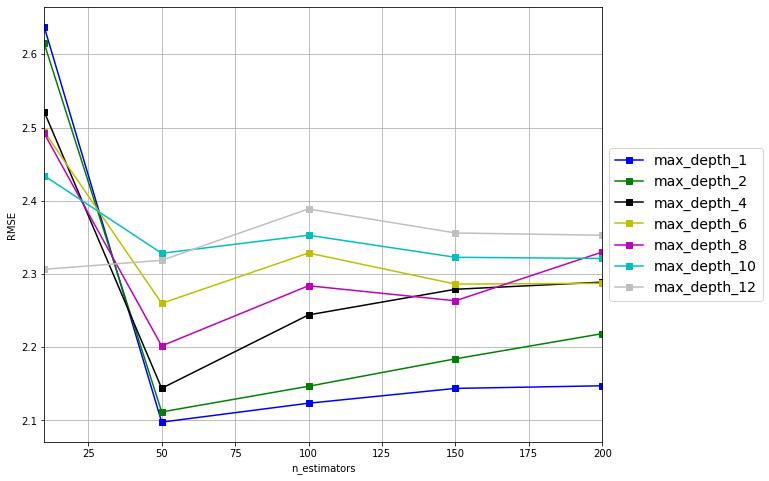

In [5940]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [5941]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 2.098
optimum params = 


(50, 1)

In [5942]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.836%
optimum params = 


(50, 2)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [5943]:
param_label = 'learning_rate'
param_list = [0.01, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = [1]
param2_list.extend(range(10, 101, 50))

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              tech_indicators,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

Minutes taken = 11.98


learning_rate  min_child_weight      rmse      mape       mae
0            0.01                 1  3.851801  3.358324  3.366612
1            0.01                10  3.830048  3.329964  3.340873
2            0.01                60  3.642575  3.175078  3.177486
3            0.10                 1  2.097683  1.839629  1.832270
4            0.10                10  2.065254  1.807391  1.804319
5            0.10                60  2.182398  1.903252  1.900567
6            0.20                 1  2.121941  1.854444  1.849500
7            0.20                10  2.098566  1.831618  1.829959
8            0.20                60  2.247264  1.960338  1.959346
9            0.30                 1  2.116885  1.850578  1.847474
10           0.30                10  2.111318  1.838468  1.836737
11           0.30                60  2.309785  2.015995  2.016161

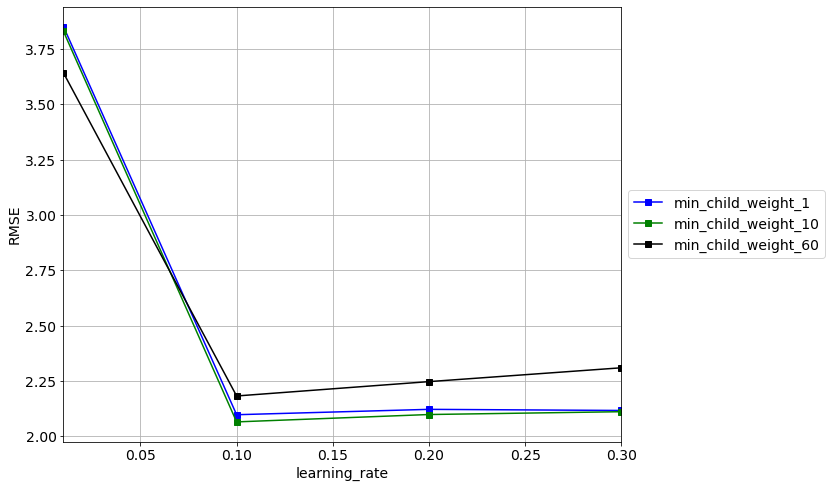

In [5944]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [5945]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 2.065
optimum params = 


(0.1, 10)

In [5946]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.807%
optimum params = 


(0.1, 10)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [5947]:
param_label = 'subsample'
param_list = [0.1, 0.5, 1]

param2_label = 'gamma'
param2_list = [0, 1, 4, 6, 8, 10]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              tech_indicators,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

Minutes taken = 18.78


subsample  gamma      rmse      mape       mae
0         0.1      0  2.179406  1.907711  1.892563
1         0.1      1  2.179406  1.907711  1.892563
2         0.1      4  2.129183  1.862746  1.846514
3         0.1      6  2.072290  1.821307  1.806271
4         0.1      8  2.116046  1.861675  1.852951
5         0.1     10  2.152461  1.888350  1.880237
6         0.5      0  2.159956  1.895969  1.886783
7         0.5      1  2.159956  1.895969  1.886783
8         0.5      4  2.170795  1.905634  1.895756
9         0.5      6  2.190941  1.922438  1.913816
10        0.5      8  2.140799  1.877461  1.870744
11        0.5     10  2.138786  1.873328  1.867567
12        1.0      0  2.065254  1.807391  1.804319
13        1.0      1  2.065254  1.807391  1.804319
14        1.0      4  2.040262  1.788519  1.784256
15        1.0      6  2.047255  1.796665  1.791943
16        1.0      8  2.063387  1.809654  1.805510
17        1.0     10  2.067996  1.814472  1.809926

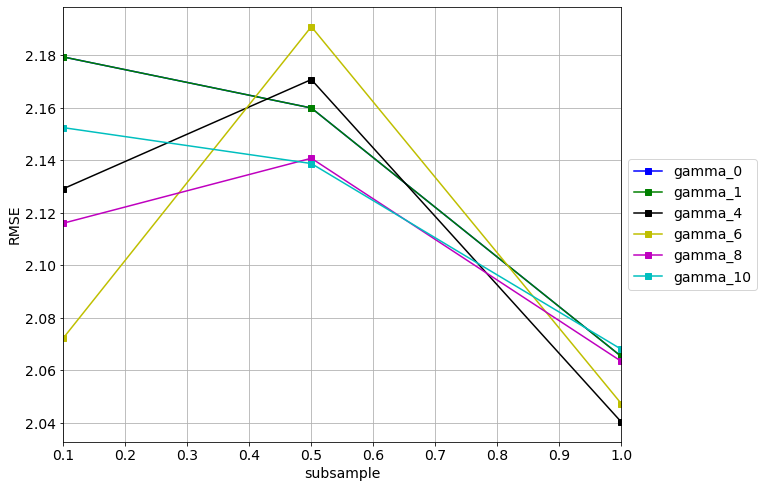

In [5948]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [5949]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 2.040
optimum params = 


(1.0, 4)

In [5950]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.789%
optimum params = 


(1.0, 4)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [5951]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _, _, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              'daily_ret',
                                                              N_opt,
                                                              tech_indicators,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

Minutes taken = 37.76


colsample_bytree  colsample_bylevel      rmse      mape       mae
0                0.5                0.5  2.056369  1.802045  1.797329
1                0.5                0.6  2.064777  1.808336  1.803700
2                0.5                0.7  2.057664  1.800699  1.796068
3                0.5                0.8  2.054515  1.798940  1.794042
4                0.5                0.9  2.059656  1.803514  1.797762
5                0.5                1.0  2.054553  1.798731  1.794377
6                0.6                0.5  2.057067  1.800916  1.796529
7                0.6                0.6  2.050772  1.796349  1.792040
8                0.6                0.7  2.062195  1.804654  1.799665
9                0.6                0.8  2.061011  1.804387  1.799443
10               0.6                0.9  2.050622  1.796286  1.791599
11               0.6                1.0  2.049849  1.795954  1.791467
12               0.7                0.5  2.059757  1.801501  1.796042
13               0.7                0.6  2.068134  1.809150  1.803980
14               0.7                0.7  2.057287  1.800745  1.795922
15               0.7                0.8  2.057351  1.802402  1.797580
16               0.7                0.9  2.047509  1.794368  1.790118
17               0.7                1.0  2.043170  1.790759  1.786644
18               0.8                0.5  2.044760  1.792163  1.788304
19               0.8                0.6  2.046225  1.793224  1.789277
20               0.8                0.7  2.050136  1.795856  1.792183
21               0.8                0.8  2.052696  1.798806  1.795348
22               0.8                0.9  2.049026  1.795202  1.791426
23               0.8                1.0  2.042353  1.789921  1.785836
24               0.9                0.5  2.044358  1.792152  1.788065
25               0.9                0.6  2.043828  1.791111  1.787237
26               0.9                0.7  2.040244  1.788106  1.783725
27               0.9                0.8  2.041582  1.788870  1.784901
28               0.9                0.9  2.044172  1.791791  1.787729
29               0.9                1.0  2.040237  1.788528  1.784238
30               1.0                0.5  2.054553  1.798731  1.794377
31               1.0                0.6  2.049849  1.795954  1.791467
32               1.0                0.7  2.043170  1.790759  1.786644
33               1.0                0.8  2.042353  1.789921  1.785836
34               1.0                0.9  2.040237  1.788528  1.784238
35               1.0                1.0  2.040262  1.788519  1.784256

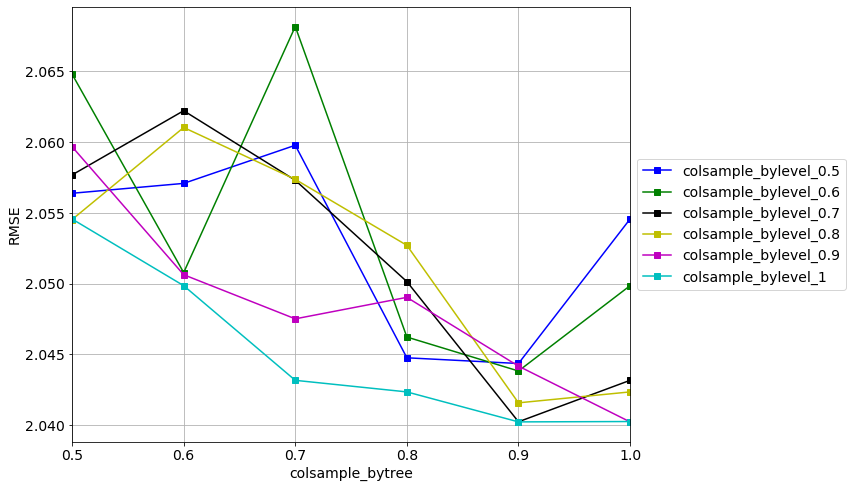

In [5952]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [5953]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 2.040
optimum params = 


(0.9, 1.0)

In [5954]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.788%
optimum params = 


(0.9, 0.7)

## Final model

In [5955]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict, _, _ = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        'daily_ret',
                                                                        N_opt,
                                                                        tech_indicators,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 2.040
MAPE = 1.789%
MAE = 1.784


In [5956]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=[val['date'].min(), val['date'].max()])
fig.update_yaxes(range=[val['adj_close'].min(), val['adj_close'].max()])
py.iplot(fig, filename='StockReturnsPrediction_v5_xgboost_val_aft_tune')

In [5957]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, preds_dict, feature_importances, features = \
                                            get_error_metrics(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       'daily_ret',
                                                                       N_opt,
                                                                       tech_indicators,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 1.278
MAPE = 1.029%
MAE = 1.164


In [5958]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=preds_dict[list(preds_dict.keys())[0]],
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [5959]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('daily_ret_lag_7', 0.0),
 ('daily_ret_lag_3', 0.0),
 ('sma_above20_lag_1', 0.0),
 ('sma_above50_lag_1', 0.0),
 ('sma_above100_lag_1', 0.0),
 ('sma_above200_lag_1', 0.0),
 ('sma_10above20_lag_1', 0.0),
 ('sma_10above50_lag_1', 0.0),
 ('sma_10above100_lag_1', 0.0),
 ('sma_10above200_lag_1', 0.0),
 ('sma_cut20_lag_1', 0.0),
 ('sma_cut50_lag_1', 0.0),
 ('sma_cut100_lag_1', 0.0),
 ('sma_cut200_lag_1', 0.0),
 ('sma_10cut20_lag_1', 0.0),
 ('sma_10cut50_lag_1', 0.0),
 ('sma_10cut100_lag_1', 0.0),
 ('sma_10cut200_lag_1', 0.0),
 ('sma_cut20down_lag_1', 0.0),
 ('sma_cut50down_lag_1', 0.0),
 ('sma_cut100down_lag_1', 0.0),
 ('sma_cut200down_lag_1', 0.0),
 ('sma_10cut20down_lag_1', 0.0),
 ('sma_10cut50down_lag_1', 0.0),
 ('sma_10cut100down_lag_1', 0.0),
 ('sma_10cut200down_lag_1', 0.0),
 ('ema_above20_lag_1', 0.0),
 ('ema_above50_lag_1', 0.0),
 ('ema_above100_lag_1', 0.0),
 ('ema_above200_lag_1', 0.0),
 ('ema_10above20_lag_1', 0.0),
 ('ema_10above50_lag_1', 0.0),
 ('ema_10above100_lag_1', 0.0),
 (

In [5960]:
# Plot the importance scores as a bar chart
fig = go.Figure(go.Bar(
            x=[item[1] for item in imp[-10:]],
            y=[item[0] for item in imp[-10:]],
            orientation='h'))
py.iplot(fig, filename='StockReturnsPrediction_v5_xgboost_imp_scores')

## Tuned params

In [5961]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

param  before_tuning  after_tuning
0        n_estimators        100.000        50.000
1           max_depth          3.000         1.000
2       learning_rate          0.100         0.100
3    min_child_weight          1.000        10.000
4           subsample          1.000         1.000
5    colsample_bytree          1.000         0.900
6   colsample_bylevel          1.000         1.000
7               gamma          0.000         4.000
8            val_rmse          2.238         2.040
9            val_mape          1.931         1.789
10            val_mae          1.935         1.784

In [5962]:
# Put tuned_params into pickle
pickle.dump(tuned_params, open("./out/v5_tuned_params_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [5964]:
toc1 = time.time()
print("Total minutes taken = {0:.2f}".format((toc1-tic1)/60.0))

Total minutes taken = 112.21


# Findings for a specific date

In [5965]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'].strftime("%Y-%m-%d"), H))

Predicting on day 1008, date 2017-01-03, with forecast horizon H = 21


In [5966]:
rmse_bef_tuning, rmse_aft_tuning

(2.237793112109458, 2.040236994029739)

In [5967]:
test_rmse_bef_tuning, test_rmse_aft_tuning

(2.1591496504576115, 1.2782531900089829)

In [5968]:
# Put results into pickle
pickle.dump(rmse_bef_tuning, open("./out/v5_val_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(rmse_aft_tuning, open("./out/v5_val_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_bef_tuning, open("./out/v5_test_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_bef_tuning, open("./out/v5_test_mape_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_bef_tuning, open("./out/v5_test_mae_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_aft_tuning, open("./out/v5_test_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_aft_tuning, open("./out/v5_test_mape_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_aft_tuning, open("./out/v5_test_mae_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(preds_dict[list(preds_dict.keys())[0]], open("./out/v5_test_est_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

# Findings across all dates

In [5969]:
# Consolidate results
# H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
# train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
# val_size = 252                 # Use 1 year of data as validation set
# N = 10                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
results = defaultdict(list)
ests = {} # the predictions
date_list = ['2017-01-03',
             '2017-03-06',
             '2017-05-04',
             '2017-07-05',
             '2017-09-01',
             '2017-11-01',
             '2018-01-03',
             '2018-03-06',
             '2018-05-04',
             '2018-07-05',
             '2018-09-04',
             '2018-11-01'
            ]
for date in date_list:
    results['date'].append(date)
    results['val_rmse_bef_tuning'].append(pickle.load(open( "./out/v5_val_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['val_rmse_aft_tuning'].append(pickle.load(open( "./out/v5_val_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_bef_tuning'].append(pickle.load(open( "./out/v5_test_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_aft_tuning'].append(pickle.load(open( "./out/v5_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mape_bef_tuning'].append(pickle.load(open( "./out/v5_test_mape_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mape_aft_tuning'].append(pickle.load(open( "./out/v5_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mae_bef_tuning'].append(pickle.load(open( "./out/v5_test_mae_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mae_aft_tuning'].append(pickle.load(open( "./out/v5_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    ests[date] = pickle.load(open( "./out/v5_test_est_aft_tuning_" + date + ".pickle", "rb"))
    
results = pd.DataFrame(results)
results

date  val_rmse_bef_tuning  val_rmse_aft_tuning  \
0   2017-01-03             2.237793             2.040237   
1   2017-03-06             2.192954             1.716339   
2   2017-05-04             2.107816             1.727910   
3   2017-07-05             1.802597             1.432437   
4   2017-09-01             1.724803             1.308719   
5   2017-11-01             1.996549             1.466308   
6   2018-01-03             1.911617             1.419230   
7   2018-03-06             2.247377             1.980193   
8   2018-05-04             2.576481             2.136851   
9   2018-07-05             2.613517             2.332496   
10  2018-09-04             2.974524             2.552925   
11  2018-11-01             3.462544             2.910742   

    test_rmse_bef_tuning  test_rmse_aft_tuning  test_mape_bef_tuning  \
0               2.159150              1.278253              1.787911   
1               0.783025              3.440361              0.587391   
2               1.447436              0.908099              1.010632   
3               2.060977              1.168315              1.446298   
4               2.733416              1.207946              1.895571   
5               1.296336              0.934279              0.650817   
6               5.520829              3.882189              3.563480   
7               3.432673              3.845798              2.037601   
8               3.350201              4.096126              2.323635   
9               3.805995              3.832735              2.567782   
10              0.809272              0.856296              0.445414   
11              2.401793              3.096558              1.469170   

    test_mape_aft_tuning  test_mae_bef_tuning  test_mae_aft_tuning  
0               1.029035             2.022072             1.164411  
1               2.653912             0.687348             3.105459  
2               0.590048             1.210255             0.705171  
3               0.856346             1.781635             1.053845  
4               0.868022             2.378988             1.087916  
5               0.492089             0.854092             0.645148  
6               2.521925             5.038320             3.564383  
7               2.286406             2.732266             3.064368  
8               2.865333             3.215904             3.964740  
9               2.596929             3.684240             3.725420  
10              0.509203             0.659094             0.754084  
11              1.853206             2.036825             2.593457

In [5970]:
# Generate a condensed dataframe of the above
results_short = defaultdict(list)
hyperparam_list = ['n_estimators', 
                   'max_depth', 
                   'learning_rate', 
                   'min_child_weight',
#                    'subsample',
#                    'colsample_bytree',
#                    'colsample_bylevel',
#                    'gamma'
                  ]

for date in date_list:
    results_short['date'].append(date)
    results_short['RMSE'].append(pickle.load(open( "./out/v5_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAPE(%)'].append(pickle.load(open( "./out/v5_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAE'].append(pickle.load(open( "./out/v5_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    
    tuned_params = pickle.load(open("./out/v5_tuned_params_" + date + ".pickle", "rb"))
    for hyperparam in hyperparam_list:
        results_short[hyperparam].append(tuned_params[tuned_params['param']==hyperparam]['after_tuning'].values[0])

    
results_short = pd.DataFrame(results_short)
results_short

date      RMSE   MAPE(%)       MAE  n_estimators  max_depth  \
0   2017-01-03  1.278253  1.029035  1.164411          50.0        1.0   
1   2017-03-06  3.440361  2.653912  3.105459          10.0       12.0   
2   2017-05-04  0.908099  0.590048  0.705171          50.0        1.0   
3   2017-07-05  1.168315  0.856346  1.053845          50.0        1.0   
4   2017-09-01  1.207946  0.868022  1.087916          50.0        1.0   
5   2017-11-01  0.934279  0.492089  0.645148          50.0        1.0   
6   2018-01-03  3.882189  2.521925  3.564383          50.0        1.0   
7   2018-03-06  3.845798  2.286406  3.064368          50.0        1.0   
8   2018-05-04  4.096126  2.865333  3.964740          50.0        1.0   
9   2018-07-05  3.832735  2.596929  3.725420          50.0        1.0   
10  2018-09-04  0.856296  0.509203  0.754084          50.0        1.0   
11  2018-11-01  3.096558  1.853206  2.593457          50.0       12.0   

    learning_rate  min_child_weight  
0             0.1              10.0  
1             0.1              10.0  
2             0.1               1.0  
3             0.1              10.0  
4             0.1               1.0  
5             0.1               1.0  
6             0.1               1.0  
7             0.1               1.0  
8             0.1              10.0  
9             0.1               1.0  
10            0.1               1.0  
11            0.1               1.0

In [5971]:
results.mean()

val_rmse_bef_tuning     2.320714
val_rmse_aft_tuning     1.918699
test_rmse_bef_tuning    2.483425
test_rmse_aft_tuning    2.378913
test_mape_bef_tuning    1.648809
test_mape_aft_tuning    1.593538
test_mae_bef_tuning     2.191753
test_mae_aft_tuning     2.119033
dtype: float64

In [5972]:
# Plot all predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'],
                         mode='lines',
                         name='adj_close',
                         line=dict(color='blue')))

# Plot the predictions
n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['date'], 
                             y=ests[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2017-01-03', '2018-12-28'])
fig.update_yaxes(range=[110, 150])
py.iplot(fig, filename='StockPricePrediction_v5_xgboost_predictions')

In [5973]:
# Plot scatter plot of actual values vs. predictions
fig = go.Figure()

n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['adj_close'], 
                             y=ests[key],
                             mode='markers',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.add_trace(go.Scatter(x=list(range(110, 155, 1)),
                         y=list(range(110, 155, 1)),
                         mode='lines',
                         name='actual values',
                         line=dict(color='blue')))

fig.update_layout(yaxis=dict(title='forecasts'),
                  xaxis=dict(title='adj_close'))
py.iplot(fig, filename='StockPricePrediction_v5_xgboost_actuals_vs_predictions')

In [6030]:
# Compare results with benchmark
all_results = pd.DataFrame({'Method': ['Last value',  'XGBoost w/o date features', 'XGBoost w date features', 'XGBoost w/o date features, w technical indicators'],
                            'RMSE': [2.53, 2.33, 2.37, 2.38],
                            'MAPE(%)': [1.69, 1.55, 1.61, 1.59],
                            'MAE': [2.26, 2.08, 2.11, 2.12]})

all_results

Method  RMSE  MAPE(%)   MAE
0                                         Last value  2.53     1.69  2.26
1                          XGBoost w/o date features  2.33     1.55  2.08
2                            XGBoost w date features  2.37     1.61  2.11
3  XGBoost w/o date features, w technical indicators  2.38     1.59  2.12